<a href="https://colab.research.google.com/github/KonstantinElfimow/household-services-analysis-04/blob/main/household_services_analysis_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Описание проекта:**

Вы работаете аналитиком в международной компании, занимающейся производством и продажами климатического оборудования: систем кондиционирования и вентиляции. На одной из выставок, посвященной климатическому оборудованию, группа инженеров из дружественной компании предоставила результаты своего исследования: данные по использованию климатических систем в офисах разных стран, городов, а также оценочные данные от респондентов по тому, насколько им комфортно было находиться в созданных температурных условиях. Руководство поставило вам задачу проанализировать полученные данные и предоставить выводы о том, в какой тип климатического оборудования стоит инвестировать больше, чтобы повысить удовлетворенность клиентов созданными условиями в зависимости от региона? И на что стоит обратить внимание при развитии бизнеса в разных регионах?

https://drive.google.com/file/d/1f3-PD9uAVNacQZR8qZGY7zBTtOcAOm98/view?usp=drive_link

In [1]:
! gdown --id 1f3-PD9uAVNacQZR8qZGY7zBTtOcAOm98

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1f3-PD9uAVNacQZR8qZGY7zBTtOcAOm98
To: /content/Данные по использованию климатических систем.csv
100% 135k/135k [00:00<00:00, 112MB/s]


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, shapiro, mannwhitneyu, ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_percentage_error, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2_contingency, f_oneway, kruskal
from typing import Tuple
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
df = pd.read_csv('/content/Данные по использованию климатических систем.csv',
                 sep=';',
                 skipinitialspace=True)
df.columns = df.columns.str.lower().str.replace(' ', '_')

# 0. Основные функции

In [4]:
def numeric_hypothesis_test(sample_1, sample_2) -> Tuple[float, str]:
  if len(sample_1) < 3 or len(sample_2) < 3:
    return np.nan, np.nan

  if shapiro(sample_1)[1] >= 0.05 and shapiro(sample_2)[1] >= 0.05:
      method = 'Стьюдент'
      p_value = ttest_ind(sample_1, sample_2, equal_var=False)[1]
  else:
      method = 'Манн-Уитни'
      p_value = mannwhitneyu(sample_1, sample_2, alternative='two-sided')[1]
  return round(p_value, 4), method

In [5]:
def correlation_ratio(categories, values) -> float:
  ssw = 0
  ssb = 0
  if np.var(values) == 0:
    return 0
  for category in categories.unique():
    subgroup = values[np.where(categories == category)[0]]
    ssw += np.sum((subgroup - np.mean(subgroup)) ** 2)
    ssb += subgroup.shape[0] * (np.mean(subgroup) - np.mean(values)) ** 2
  try:
    return round((ssb / (ssb + ssw)) ** 0.5, 2)
  except ZeroDivisionError as ex:
    return np.nan

In [6]:
def crammer_and_pvalue(df, col1: str, col2: str) -> Tuple[float, float]:
  data = pd.crosstab(df[col1], df[col2])
  if data.isnull().all().all():
    return np.nan, np.nan
  data = data.fillna(0).astype(int)
  data = data.to_numpy()
  chi2, p_value = chi2_contingency(data, correction=True)[:2]
  n = np.sum(data)
  min_dim = min(data.shape) - 1
  corr = np.sqrt((chi2 / n) / min_dim)
  return round(corr, 2), round(p_value, 4)

In [7]:
# функция для проверки гипотез с несколькими группами
def multi_group_analyze(df, column1, column2):
    data_groups = list(df[column1].unique())

    groups = []
    tests = []

    for i in range(len(data_groups)):
        group_data = df[df[column1] == data_groups[i]][column2]
        group_data = group_data.dropna()
        _, p_value_shapiro = shapiro(group_data)
        groups.append(group_data)
        tests.append(p_value_shapiro)

    check = all(value >= 0.05 for value in tests)

    if check == True:
      stat, p_value = f_oneway(*groups)
      print(f'ANOVA, Стастистика: {stat}, p-value: {p_value}')
    else:
      stat, p_value = kruskal(*groups)
      print(f'Краскел-Уоллес, стастистика: {stat}, p-value: {p_value}')

# 1. Исследование данных на качество и предобработка

In [8]:
# напишем функцию первичной проверки данных
def check_data(data_df):
  print('\033[1m' + 'Изучим исходные данные' + '\033[0m')
  print(data_df.info())
  # проверим nan
  print('\033[1m' + '\nПроверка пропусков' + '\033[0m')
  print('Количество пропусков:\n{:.0f}'.format(data_df.isnull().sum().sum()))
  print('Доля пропусков:\n{}'.format(data_df.isna().mean()))
  # проверим дубликаты
  print('\033[1m' + '\nПроверка на дубликаты' + '\033[0m')
  print('Количество полных дубликатов:\n', data_df.duplicated().sum())
  # посмотрим на сами данные
  print('\033[1m' + '\nПервые 10 строк датасета' + '\033[0m')
  display(data_df.head(10))

  print('\033[1m' + '\nОписание количественных данных:' + '\033[0m')
  display(data_df.describe(exclude=['object', 'category']).T)

  print('\033[1m' + '\nОписание категориальных данных:' + '\033[0m')
  display(data_df.describe(include=['object', 'category']).T)

  print('\033[1m' + '\nВывод уникальных значений'\
  ' по каждому признаку:' + '\033[0m')

  for i in data_df.columns:
    print('\033[1m' + str(i) + '\033[0m')
    display(data_df[i].value_counts().sort_index())

In [9]:
check_data(df)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484 entries, 0 to 483
Data columns (total 30 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   год                                          484 non-null    float64
 1   время_года                                   484 non-null    object 
 2   климат                                       484 non-null    object 
 3   город                                        484 non-null    object 
 4   страна                                       484 non-null    object 
 5   способ_охлаждения                            484 non-null    object 
 6   режим_при_смешанном_типе_охлаждения          337 non-null    object 
 7   способ_обогрева                              222 non-null    object 
 8   возраст                                      413 non-null    float64
 9   пол                                          412 non-

,год,время_года,климат,город,страна,способ_охлаждения,режим_при_смешанном_типе_охлаждения,способ_обогрева,возраст,пол,ощущение_температуры,ощущение_температуры_(bool),предпочтительное_изменение_температуры,ощущение_движения_воздуха_(bool),предпочтительное_изменение_движения_воздуха,оценка_комфорта,утепление,температура_воздуха_в_помещении,температура_воздуха_на_улице,rh,скорость_воздуха,рост,вес,занавески,вентилятор,окно,двери,отопление,среднемесячная_температура_на_улице,количество_рекламаций
0,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,22.0,NaN,0.0,1.0,Без изменений,NaN,Без изменений,3.5,0.54,22.9,22.8,48.9,0.26,NaN,NaN,1.0,1.0,NaN,NaN,NaN,28.9,0
1,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,40.0,NaN,-2.0,1.0,Без изменений,NaN,Без изменений,6.0,0.61,74.8,23.7,39.2,0.12,NaN,NaN,0.0,0.0,NaN,NaN,NaN,84.0,0
2,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,42.0,NaN,1.0,1.0,Без изменений,NaN,Без изменений,5.0,0.57,25.6,24.5,34.7,0.08,NaN,NaN,0.0,0.0,NaN,NaN,NaN,32.8,0
3,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,27.0,NaN,-0.5,0.0,Теплее,NaN,Без изменений,2.5,0.61,24.2,23.8,50.0,27.16,NaN,NaN,1.0,1.0,NaN,NaN,NaN,28.9,1
4,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,46.0,NaN,0.0,1.0,Без изменений,NaN,Меньше,4.5,0.57,23.8,24.1,35.8,63.83,NaN,NaN,1.0,1.0,NaN,NaN,NaN,32.8,0
5,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,27.0,NaN,0.0,1.0,Без изменений,NaN,Без изменений,5.0,0.54,24.0,23.9,34.8,0.21,NaN,NaN,1.0,1.0,NaN,NaN,NaN,28.9,0
6,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,32.0,NaN,-1.0,1.0,Теплее,NaN,Меньше,3.5,0.57,24.7,24.8,42.2,0.10,NaN,NaN,1.0,1.0,NaN,NaN,NaN,32.8,0
7,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,30.0,NaN,-2.0,1.0,Теплее,NaN,Без изменений,4.3,0.61,74.8,23.6,40.0,0.09,NaN,NaN,0.0,0.0,NaN,NaN,NaN,32.8,0
8,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,43.0,NaN,0.0,1.0,Без изменений,NaN,Без изменений,5.0,0.57,25.5,25.5,34.7,0.15,NaN,NaN,1.0,1.0,NaN,NaN,NaN,32.8,0
9,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,43.0,NaN,1.0,0.0,Холоднее,NaN,Больше,4.0,0.61,76.4,24.4,34.5,0.34,NaN,NaN,0.0,0.0,NaN,NaN,NaN,31.7,0



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
год,484.0,2011.033058,0.922988,2010.00,2010.000,2011.00,2012.000,2012.00
возраст,413.0,40.634383,11.001301,22.00,35.000,42.00,45.000,65.00
ощущение_температуры,484.0,0.203306,1.091976,-3.00,0.000,0.00,1.000,3.00
ощущение_температуры_(bool),484.0,0.789256,0.408259,0.00,1.000,1.00,1.000,1.00
ощущение_движения_воздуха_(bool),198.0,0.752525,0.432639,0.00,1.000,1.00,1.000,1.00
оценка_комфорта,215.0,4.772093,1.261161,1.00,4.000,5.00,6.000,6.00
утепление,484.0,0.634587,0.253103,0.36,0.460,0.59,0.700,2.08
температура_воздуха_в_помещении,484.0,26.072107,7.681363,16.20,23.800,24.60,25.900,77.00
температура_воздуха_на_улице,72.0,24.104167,0.604546,22.80,23.800,24.10,24.400,25.90
rh,484.0,52.973760,13.036204,23.80,42.775,53.75,62.325,85.10



Описание категориальных данных:


,count,unique,top,freq
время_года,484,4,Лето,372
климат,484,6,Cубтропический океанический,269
город,484,8,Сидней,198
страна,484,3,Индия,214
способ_охлаждения,484,3,Смешанный,337
режим_при_смешанном_типе_охлаждения,337,2,Кондиционирование,237
способ_обогрева,222,1,Механическое отопление,222
пол,412,2,Мужской,254
предпочтительное_изменение_температуры,484,5,Без изменений,288
предпочтительное_изменение_движения_воздуха,484,3,Без изменений,291



Вывод уникальных значений по каждому признаку:
год


2010.0    198
2011.0     72
2012.0    214
Name: год, dtype: int64

время_года


Весна     18
Зима      81
Лето     372
Осень     13
Name: время_года, dtype: int64

климат


Cубтроп океанич                       1
Cубтропический океанический         269
Влажный субтропический муссонный     35
Жаркий полузасушливый                70
Субтропическое высокогорье           32
Тропическая влажная саванна          77
Name: климат, dtype: int64

город


Ахмедабад      38
Бангалор       26
Дели           35
Сидней        198
Техас          72
Хайдарабад     32
Ченнай         51
Шимла          32
Name: город, dtype: int64

страна


Австралия    198
Индия        214
США           72
Name: страна, dtype: int64

способ_охлаждения


Вентиляция            33
Кондиционирование    114
Смешанный            337
Name: способ_охлаждения, dtype: int64

режим_при_смешанном_типе_охлаждения


Вентиляция           100
Кондиционирование    237
Name: режим_при_смешанном_типе_охлаждения, dtype: int64

способ_обогрева


Механическое отопление    222
Name: способ_обогрева, dtype: int64

возраст


22.0     2
23.0     1
25.0    67
26.0     4
27.0     3
28.0     3
29.0     3
30.0     3
31.0     3
32.0     4
34.0     5
35.0    91
36.0     3
37.0     1
38.0     5
39.0     4
40.0     2
41.0     1
42.0     3
43.0     5
45.0    99
46.0     4
48.0     1
50.0     2
51.0     3
52.0     1
55.0    77
58.0     1
65.0    12
Name: возраст, dtype: int64

пол


Женский    158
Мужской    254
Name: пол, dtype: int64

ощущение_температуры


-3.0      1
-2.0     22
-1.5      1
-1.4      1
-1.3      1
-1.0     68
-0.5     10
-0.4      2
-0.2      1
-0.1      1
 0.0    225
 0.2      1
 0.5      6
 0.6      1
 0.8      2
 1.0     79
 1.1      5
 1.2      3
 1.5      2
 1.6      2
 2.0     26
 3.0     24
Name: ощущение_температуры, dtype: int64

ощущение_температуры_(bool)


0.0    102
1.0    382
Name: ощущение_температуры_(bool), dtype: int64

предпочтительное_изменение_температуры


Без изменений    288
Тепле              2
Теплее            58
Холодн             2
Холоднее         134
Name: предпочтительное_изменение_температуры, dtype: int64

ощущение_движения_воздуха_(bool)


0.0     49
1.0    149
Name: ощущение_движения_воздуха_(bool), dtype: int64

предпочтительное_изменение_движения_воздуха


Без изменений    291
Больше           161
Меньше            32
Name: предпочтительное_изменение_движения_воздуха, dtype: int64

оценка_комфорта


1.0     1
2.0     9
2.2     1
2.3     1
2.5     3
2.7     1
2.8     1
3.0    21
3.5     7
4.0    27
4.3     1
4.5     5
5.0    54
5.2     1
6.0    82
Name: оценка_комфорта, dtype: int64

утепление


0.36     2
0.37     6
0.38     4
0.39    18
0.40     7
0.41    18
0.42     7
0.43    17
0.44     3
0.45     1
0.46    64
0.47     1
0.48     1
0.49     4
0.50     5
0.51     1
0.52    10
0.53     5
0.54    11
0.55    11
0.56     3
0.57    37
0.58     3
0.59     7
0.60     2
0.61    33
0.62    10
0.63     8
0.64    12
0.65     1
0.66     5
0.67     8
0.68    26
0.69     2
0.70    17
0.71     5
0.72    13
0.73     4
0.74    14
0.75     6
0.77     1
0.78     5
0.79     4
0.80     1
0.81     2
0.82     1
0.83     1
0.84     7
0.85     1
0.86     1
0.87     1
0.88     1
0.90     2
0.91     1
0.92     3
0.93     1
0.94     1
0.96     2
0.97     8
1.00     1
1.02     1
1.03     1
1.04     1
1.05     1
1.11     1
1.12     2
1.19     1
1.22     1
1.32     1
1.40     1
1.41     1
1.44     1
1.45     2
1.47     1
1.48     1
1.59     1
1.67     1
1.68     1
1.69     1
1.74     2
1.75     1
1.83     1
2.06     1
2.08     1
Name: утепление, dtype: int64

температура_воздуха_в_помещении


16.2     1
17.0     1
17.5     1
17.6     1
18.0     1
18.3     1
18.7     1
18.9     1
19.4     1
20.0     1
20.2     3
20.4     1
20.5     1
20.6     1
21.1     3
21.3     1
21.4     1
21.6     1
21.7     1
21.8     3
21.9     5
22.0     2
22.1     3
22.2     3
22.3     4
22.4     3
22.5     4
22.6     4
22.7     3
22.8     2
22.9     7
23.0     2
23.1     6
23.2     6
23.3     4
23.4     4
23.5     8
23.6     9
23.7    10
23.8    10
23.9    10
24.0    14
24.1    16
24.2    14
24.3    17
24.4    20
24.5    16
24.6    14
24.7    12
24.8    12
24.9     8
25.0    12
25.1    12
25.2    15
25.3    13
25.4     9
25.5     4
25.6     4
25.7     8
25.8     7
25.9     3
26.0     4
26.1     6
26.2     2
26.3     6
26.4     2
26.5     2
26.6     5
26.7     4
26.8     3
26.9     6
27.0     2
27.1     2
27.2     1
27.3     2
27.5     7
27.6     2
27.7     2
27.8     2
27.9     3
28.0     1
28.1     2
28.2     3
28.3     1
28.4     1
28.6     1
28.7     2
28.8     2
28.9     1
29.2     1
29.3     2

температура_воздуха_на_улице


22.8     1
22.9     1
23.0     3
23.1     1
23.3     1
23.4     1
23.6     4
23.7     3
23.8     6
23.9     8
24.0     6
24.1    10
24.2     6
24.3     2
24.4     2
24.5     2
24.6     2
24.7     3
24.8     2
24.9     2
25.0     1
25.1     1
25.2     1
25.5     2
25.9     1
Name: температура_воздуха_на_улице, dtype: int64

rh


23.8    1
23.9    1
26.3    1
26.5    1
26.6    1
26.8    1
27.0    1
27.7    1
27.8    1
28.3    1
28.8    1
28.9    1
30.0    1
30.1    1
30.8    1
31.0    2
31.2    2
31.5    1
31.7    1
32.0    1
32.1    1
32.2    1
33.0    1
33.1    1
33.3    1
33.4    1
34.0    3
34.1    2
34.2    1
34.3    1
34.4    1
34.5    2
34.6    1
34.7    2
34.8    2
34.9    2
35.0    2
35.1    1
35.3    2
35.6    1
35.7    1
35.8    2
35.9    1
36.0    4
36.4    1
36.8    1
36.9    1
37.4    1
37.6    3
37.9    2
38.0    2
38.1    1
38.2    1
38.3    1
38.4    3
38.5    1
38.7    1
38.9    1
39.0    1
39.1    1
39.2    4
39.4    2
39.5    2
39.6    1
39.8    1
40.0    6
40.1    1
40.2    1
40.4    1
40.8    1
41.0    4
41.3    1
41.4    1
41.8    1
42.0    5
42.1    2
42.2    3
42.3    1
42.6    1
42.7    1
42.8    2
43.0    2
43.1    1
43.2    1
43.5    2
43.6    2
43.7    1
43.8    2
43.9    2
44.0    3
44.1    1
44.2    1
44.3    2
44.5    1
44.6    1
44.8    1
44.9    1
45.0    2
45.1    2
45.2    2


скорость_воздуха


0.00      4
0.01     13
0.02     23
0.03     18
0.04     19
0.05     20
0.06     25
0.07     37
0.08     48
0.09     34
0.10     24
0.11     42
0.12     26
0.13     17
0.14     15
0.15      7
0.16     11
0.17      6
0.18      8
0.19      6
0.20      3
0.21      9
0.22      5
0.23      3
0.24      1
0.25      2
0.26      2
0.27      1
0.28      2
0.29      1
0.31      4
0.32      7
0.33      3
0.34      3
0.35      1
0.36      1
0.38      1
0.39      1
0.40      1
0.41      2
0.45      1
0.47      1
0.48      1
0.50      2
0.53      1
0.54      1
0.56      2
0.57      1
0.60      1
0.65      1
0.77      1
0.82      1
1.00      1
1.23      1
1.42      1
1.43      1
8.20      1
14.85     1
18.65     1
22.68     1
26.49     1
27.16     1
29.61     1
46.00     1
47.97     1
63.83     1
Name: скорость_воздуха, dtype: int64

рост


5.23       1
5.74       1
134.60     1
144.80     1
147.30     1
152.40     7
154.90     2
157.50    16
160.00    17
161.30     1
162.60    15
163.00     1
164.00     1
165.10     8
167.00     3
167.60    13
168.00     1
170.20    11
172.00     2
172.70     8
174.00     2
175.00     1
175.30     7
177.80     5
178.00     1
180.00     2
180.30     4
182.90     3
185.40     1
188.00     5
190.50     1
Name: рост, dtype: int64

вес


42.0      2
43.0      1
44.0      2
45.0      2
47.0      2
48.0      3
49.0      2
50.0      6
52.0      4
53.0      2
54.0      2
55.0     13
56.0     11
57.0      7
58.0     11
59.0      2
60.0     13
61.0      2
62.0      3
63.0      4
64.0      4
65.0     21
67.0      7
68.0      9
69.0      1
70.0     19
71.0      3
72.0      2
73.0      3
74.0      3
75.0     10
76.0      6
77.0      1
78.0      2
79.0      2
80.0      6
81.0      1
82.0      3
83.0      1
84.0      1
85.0      6
86.0      1
89.0      1
90.0      2
92.0      1
95.0      3
110.0     1
Name: вес, dtype: int64

занавески


0.0    35
1.0    37
Name: занавески, dtype: int64

вентилятор


0.0    69
1.0    77
Name: вентилятор, dtype: int64

окно


0.0    210
1.0     69
Name: окно, dtype: int64

двери


0.0    128
1.0     29
Name: двери, dtype: int64

отопление


0.0    17
1.0    62
Name: отопление, dtype: int64

среднемесячная_температура_на_улице


8.5       14
15.5      14
18.5      18
21.3      12
21.6      17
22.0     197
25.7       3
27.0       5
28.9      23
29.4       1
29.5      26
29.7      10
29.9      10
30.4      11
30.8      30
30.9      21
31.5       7
31.7      14
32.8      23
38.1      16
84.0       4
89.0       2
91.0       4
220.0      1
328.0      1
Name: среднемесячная_температура_на_улице, dtype: int64

количество_рекламаций


0    450
1     24
2      3
3      7
Name: количество_рекламаций, dtype: int64

**Выводы:**
0. Есть ошибки в определении типов данных.
1. Летом нам неважно, есть ли отопление или нет. Наверное
2. Если предпочтительное изменение движения воздуха = без изменений, то следовательно, заказчика всё устраивает и он считает это **приемлемым**. Тогда Na можно заполнить на приемлемое (= 1) в предпочтительное изменение движения воздуха (bool)
3. Na в колонке с температурой на улице можно заменить на медианную в данном городе, данном году и сезоне или вообще взять среднемесячную температуру.
4. Открыт вопрос значимости колонок роста и веса, возможно, их стоит дропнуть. В росте были замечены выбросы в меньшую сторону. Скорее всего, используется не метрическая система. И нужно перевести футы в см.
5. Есть выбросы в температуре воздуха в помещении. Это связано с тем, что температура была измерена в Фаренгейт (скорее всего), значения получаются хорошие, если перевести в Цельсии. Вопрос, на который стоит ответить, используется в данной стране не метрическая система?
6. В скорости воздуха есть большие выбросы.
7. Есть ошибки в значениях климат и предпочтительное изменение температуры.
8. Есть выбросы в среднемесячной температуре на улице, но там не только Фаренгейты, но и ошибка в постановке знака после запятой для 3-х значных чисел.
9. Есть вариант заполнить Nan в занавесках, вентиляторе, окне, дверям и отоплению по их взаимосвязи между собой, а также по способу охлаждения.
10. Есть 2 полных дубликата.
11. Выяснился также интересный факт: что в период 2010-2012 года было только по одной стране. А значит, временные ряды анализировать не придётся. Ещё это значит, что группы полностью независимы и их анализ можно проводить отдельно друг от друг. Это увеличит достоверность проверок гипотез в данных, а также может повлиять на методы борьбы с выбросами для этих групп! Доказательство о независимости:

In [10]:
df.groupby('год')['страна'].value_counts(normalize=True).to_frame()

,,страна
год,страна,
2010.0,Австралия,1.0
2011.0,США,1.0
2012.0,Индия,1.0


## 1.1 Приведение данных к правильному типу

In [11]:
# приводим год к datetime
col = 'год'
df[col] = pd.to_datetime(df[col].astype(int).astype(str) + '-01-01')

# Исправляем ошибки: 'Cубтроп океанич' на 'Cубтропический океанический',
# Тепле на Теплее и Холодн на Холоднее
col = 'климат'
df[col] = df[col].replace(to_replace={'Cубтроп океанич': 'Cубтропический океанический'})
col = 'предпочтительное_изменение_температуры'
df[col] = df[col].replace(to_replace={'Тепле': 'Теплее', 'Холодн': 'Холоднее'})

# Округляем по математическому правилу оценку комфорта
col = 'оценка_комфорта'
df[col] = df[col].round(0)

## 1.2 Удаляем полные дубликаты

In [12]:
df = df.drop_duplicates().reset_index(drop=True)

## 1.3 Обработка выбросов

Сделаем сначала наиболее очевидную обработку выбросов.

### 1.3.1 Выбросы в температуре

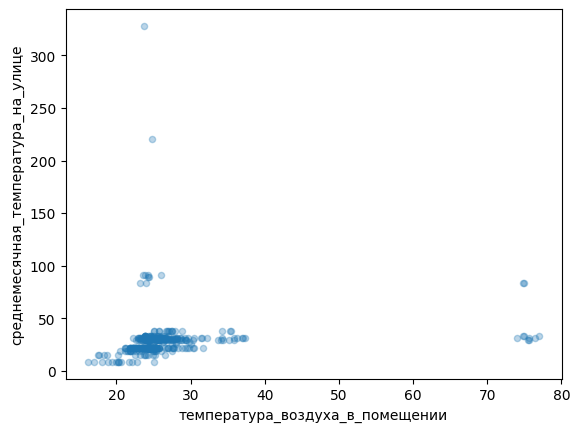

In [13]:
df.plot(x='температура_воздуха_в_помещении',
        y='среднемесячная_температура_на_улице',
        kind='scatter', alpha=0.3);

In [14]:
# Руководствуясь здравым смыслом, можно предополжить, что вряд ли температура
# воздуха в США, Австралии или Индии была бы выше 40 градусов в среднем по месяцу.
# Также вряд ли есть предприятия, где прижилась бы система охлаждения при >70
# градусов Цельсия. Это очевидно выбросы.

In [15]:
# Мы хотим проверить можно ли перевести из Фаренгейт в Цельсии, но надо знать
# оправданы ли наши подозрения. Может, в этой стране используют только Цельсии
# как основную меру температуры.
col = 'температура_воздуха_в_помещении'
index1 = df[df[col] > 60].index.tolist()
col = 'среднемесячная_температура_на_улице'
index2 = df[(50 < df[col]) & (df[col] < 100)].index.tolist()

index = list(set(index1) & set(index2))
df.loc[index, 'страна'].value_counts(normalize=True)

США    1.0
Name: страна, dtype: float64

In [16]:
# Выбросы только по данным в США. Там чаще пользуются Фаренгейтами,
# чем Цельсиями, поэтому неудивительно, что такие выбросы возникли.
# Можно смело пользоваться формулой по переводу из Фаренгейт в Цельсии.
# Мы доказали, что выбросы связаны с особенностями системы измерения страны.

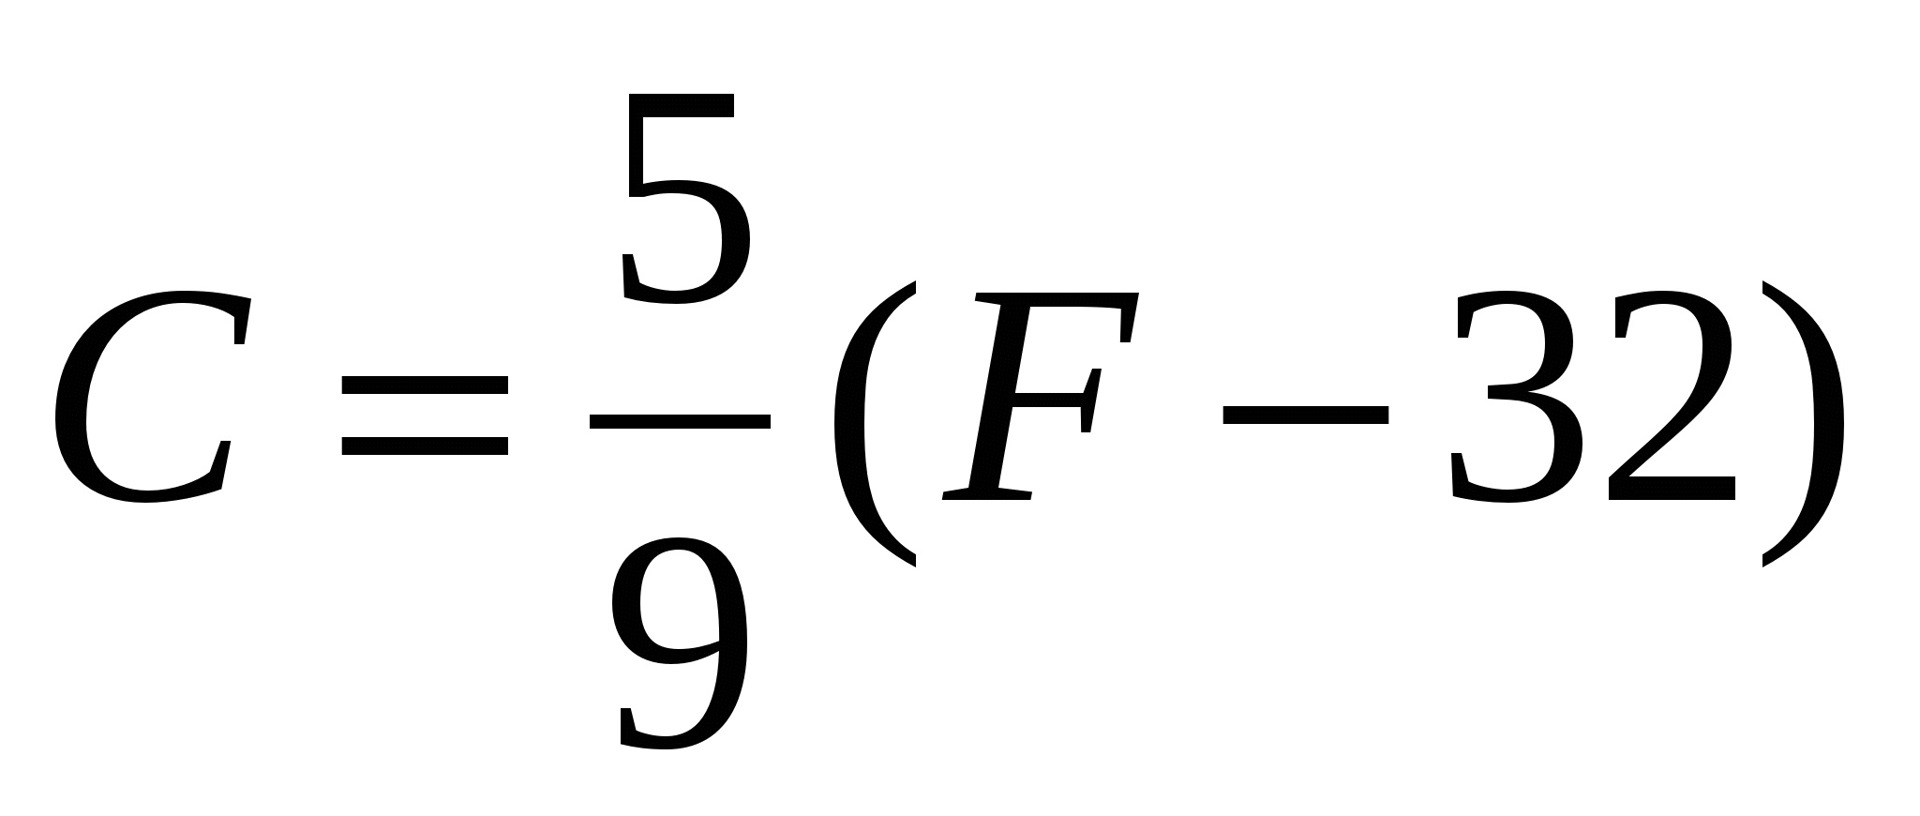

In [17]:
# Обработаем выбросы в температуре воздуха в помещении
col = 'температура_воздуха_в_помещении'
index = df[df[col] > 60].index.tolist()
df.loc[index, col] = round((5 / 9) * (df.loc[index, col] - 32), 1)

In [18]:
# Обработаем выбросы в среднемесячной температуре
col = 'среднемесячная_температура_на_улице'
index1 = df[(50 < df[col]) & (df[col] < 100)].index.tolist()
df.loc[index1, col] = round((5 / 9) * (df.loc[index1, col] - 32), 1)
index2 = df[df[col] >= 100].index.tolist()
df.loc[index2, col] = round(df.loc[index2, col] / 10, 1)

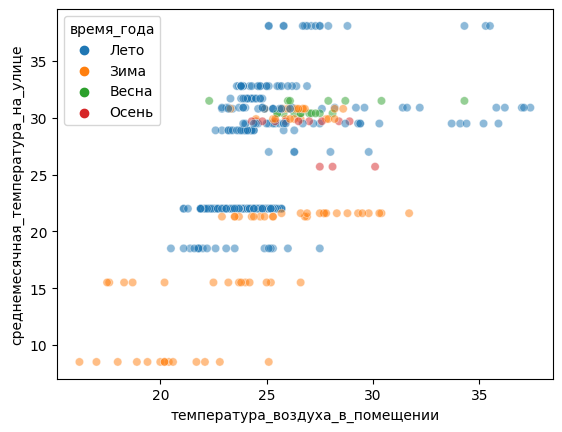

In [19]:
sns.scatterplot(data=df, x='температура_воздуха_в_помещении',
                y='среднемесячная_температура_на_улице',
                alpha=0.5, hue='время_года');

### 1.3.2 Выбросы в росте

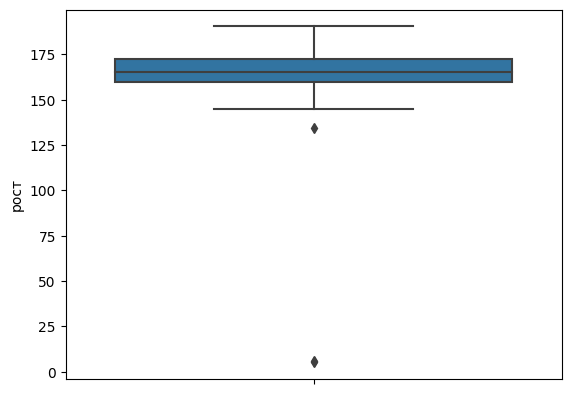

In [20]:
sns.boxplot(data=df, y='рост');

In [21]:
# Видим выброс в меньшую сторону. Посмотрим, может, снова используется
# другая мера длины.
q1, q3 = df['рост'].quantile(0.25), df['рост'].quantile(0.75)
h = q3 - q1
index = df[df['рост'] < q1 - 3 * h].index.to_list()
for_replace = df.loc[index, ['рост', 'страна']]

display(for_replace)
display(for_replace['страна'].value_counts(normalize=True))

,рост,страна
287,5.23,Индия
306,5.74,Индия


Индия    1.0
Name: страна, dtype: float64

In [22]:
# а вот тут уже сложно ответить это фут или местная Индийская единица измерения
# длины. Если фут, то значения выходят довольно сносными, но если это Индийская
# Илахи Газ, то рост человека выходит под 4 метра. Самый правильный путь -
# заменить эти выбросы на медианное значение роста человека в Индии. Пусть чуть
# в качестве данных мы и потеряем, но этих значений всего 2, поэтому можем
# потерпеть.

df.loc[index, 'рост'] = df.groupby(['страна', 'пол'])['рост'].transform('median')

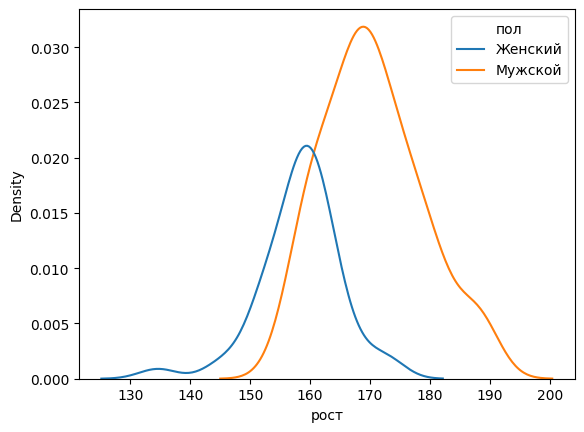

In [23]:
sns.kdeplot(data=df, x='рост', hue='пол');

In [24]:
# теперь всё круто!

**Доп**
> Проверю гипотезу о том, что мужчины в среднем выше женщин в любой из стран.

In [25]:
mtest = []
target = 'рост'
for country in df['страна'].unique():
    sample_1 = df[(df['страна'] == country) & (df['пол'] == 'Мужской')][target]
    sample_2 = df[(df['страна'] == country) & (df['пол'] == 'Женский')][target]

    sample_1 = sample_1.dropna()
    sample_2 = sample_2.dropna()
    p_value, method = numeric_hypothesis_test(sample_1, sample_2)
    mtest.append([country, p_value, method])

mtest.sort(key=lambda x: x[1])
mtest.insert(0, ['показатель', 'р-уровень', 'метод расчёта'])
mtest = pd.DataFrame(mtest[1:], columns=mtest[0])
display(mtest)

,показатель,р-уровень,метод расчёта
0,США,NaN,NaN
1,Австралия,NaN,NaN
2,Индия,0.0,Манн-Уитни


**Вывод:**
> Очень не хватает данных по Австралии и США. Однако стат разница в Индии есть.

In [26]:
df[(df['страна'] == 'Индия')].groupby('пол')['рост'].mean().round(0)

пол
Женский    158.0
Мужской    170.0
Name: рост, dtype: float64

### 1.3.3 Выбросы в скорости воздуха

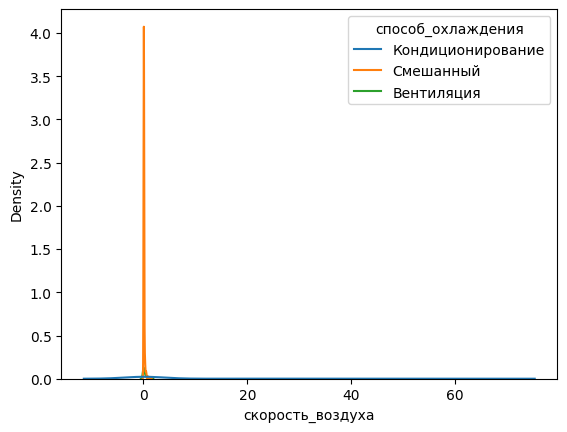

In [27]:
sns.kdeplot(data=df, x='скорость_воздуха', hue='способ_охлаждения');

In [28]:
for freezer in df['способ_охлаждения'].unique():
  print('\033[1m' + freezer + '\033[0m')
  display(df[df['способ_охлаждения'] == freezer]['скорость_воздуха']
          .describe()
          .to_frame()
          .T)
  print('\n')

Кондиционирование


,count,mean,std,min,25%,50%,75%,max
скорость_воздуха,114.0,2.82,9.890699,0.03,0.1,0.13,0.21,63.83




Смешанный


,count,mean,std,min,25%,50%,75%,max
скорость_воздуха,335.0,0.118896,0.141077,0.0,0.06,0.09,0.12,1.42




Вентиляция


,count,mean,std,min,25%,50%,75%,max
скорость_воздуха,33.0,0.204848,0.318474,0.0,0.03,0.06,0.19,1.43


In [29]:
# Замечаем жирный хвост в данных по скорости воздуха Кондиционера и другие выбросы.
# Можно было бы предложить,  что скорость воздуха системы охлаждения измерили
# в км/ч, но такие предположения слишком рискованные.
# Лучший вариант - это заменить на медианное значение скорость воздуха. Вот
# нужно понять подойдёт обычная медиана или по каждому типу охлаждения отдельно.
# Проверим гипотезу о статистической разнице систем охлаждения и скорости воздуха.
# Без учёта этих выбросов в Кондиционировании, доходящих до абсурда.

# Я бы не стал убирать выбросы в Смешанном и Вентиляции, потому что, возможно,
# cуществует некоторая проблема с установленными системами.

target = 'скорость_воздуха'

group1 = 'Вентиляция'
group2 = 'Кондиционирование'

col1 = 'способ_охлаждения'
col2 = 'режим_при_смешанном_типе_охлаждения'

q1 = df[df[col1] == group2][target].quantile(0.25)
q3 = df[df[col1] == group2][target].quantile(0.75)

h = q3 - q1
index = df[~((df[target] > q3 + 3 * h) & (df[col1] == group2))].index.to_list()
temp = df.loc[index, :]

sample_1 = pd.concat(
    [temp[temp[col1] == group1][target], temp[temp[col2] == group1][target]]
    )
sample_2 = pd.concat(
    [temp[temp[col1] == group2][target], temp[temp[col2] == group2][target]]
    )

p_value, method = numeric_hypothesis_test(sample_1, sample_2)
print(f'Метод: {method}', f'p-value: {p_value}', sep='\n')

Метод: Манн-Уитни
p-value: 0.0


In [30]:
# Видим, что стат разница есть, данные пришли из разных распределений

for_replace = df[(df[target] > q3 + 3 * h) & (df[col1] == group2)].index.to_list()
df.loc[for_replace, target] = df.groupby('способ_охлаждения')[target].transform('median')

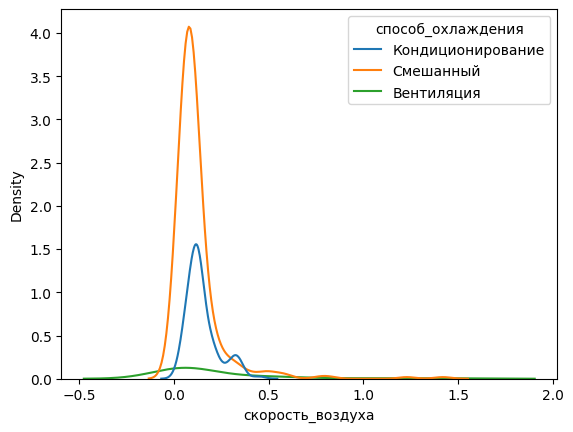

In [31]:
sns.kdeplot(data=df, x='скорость_воздуха', hue='способ_охлаждения');

In [32]:
print(np.max(sample_1))
print(np.max(sample_2))

1.43
1.42


In [33]:
# Возможно, всё что больше 1 - это отдельная система, которая как-то связана
# с количеством жалоб или чем-то ещё связанным. Проверим
df.corr(method='spearman')['скорость_воздуха'].sort_values()

оценка_комфорта                       -0.293205
ощущение_движения_воздуха_(bool)      -0.202354
rh                                    -0.111868
утепление                             -0.104868
ощущение_температуры_(bool)           -0.087086
температура_воздуха_на_улице          -0.076544
возраст                               -0.074050
вес                                   -0.050538
двери                                 -0.016685
рост                                  -0.005840
отопление                             -0.002030
ощущение_температуры                  -0.000378
количество_рекламаций                  0.124546
температура_воздуха_в_помещении        0.201116
окно                                   0.244011
среднемесячная_температура_на_улице    0.510130
занавески                              0.582588
вентилятор                             0.698689
скорость_воздуха                       1.000000
Name: скорость_воздуха, dtype: float64

In [34]:
# Проверим стат значимость скорости воздуха с включенным и выключенным вентилятором

sample_1 = df[df['вентилятор'] == 0]['скорость_воздуха']
sample_2 = df[df['вентилятор'] == 1]['скорость_воздуха']

p_value, method = numeric_hypothesis_test(sample_1, sample_2)
print(f'Метод: {method}', f'p-value: {p_value}', sep='\n')

Метод: Манн-Уитни
p-value: 0.0


In [35]:
# Сред отличаются
print(round(sample_1.mean(), 2))
print(round(sample_2.mean(), 2))

0.1
0.29


In [36]:
# Следовательно, выбросы имеют свою природу, а не взялись по ошибке

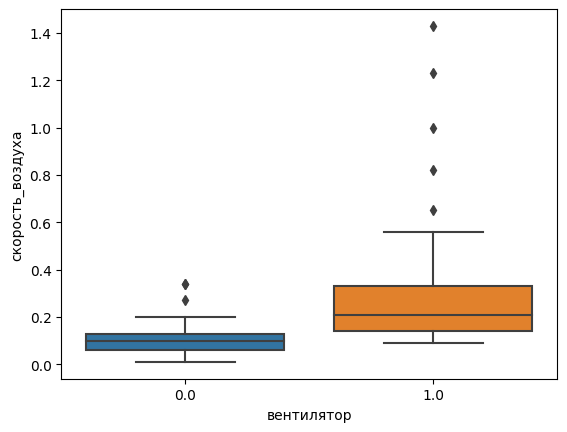

In [37]:
sns.boxplot(data=df, x='вентилятор', y='скорость_воздуха');

### 1.3.4 Выбросы в утеплении

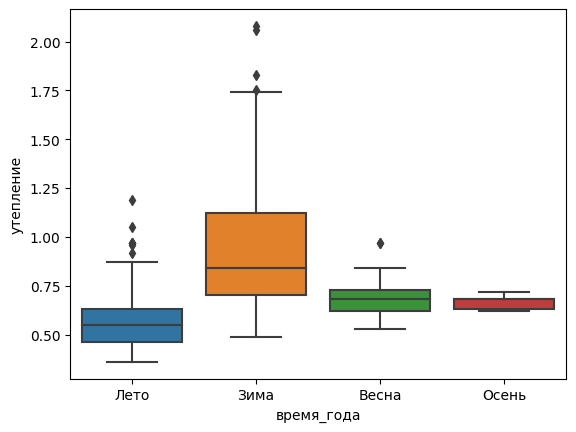

In [38]:
sns.boxplot(data=df, y='утепление', x='время_года');

In [39]:
for season in df['время_года'].unique():
  for climate in df['климат'].unique():
    sample = df[(df['время_года'] == season) & (df['климат'] == climate)]['утепление']
    q1, q3 = sample.quantile(0.25), sample.quantile(0.75)
    h = q3 - q1
    index = sample[sample > q3 + 3 * h].index.to_list()
    if len(index) > 0:
      print(season)
      print(climate)
      print(len(index))
      df.loc[index, 'утепление'] = sample.median()

Лето
Жаркий полузасушливый
1
Лето
Тропическая влажная саванна
2


In [40]:
# Избавились от нескольких выбросов в утеплении Летом

### Выводы
1. Мы избавились от выбросов в данных температуры. Выяснили, что была использована не метрическая система, поэтому воспользовались формулой по переводу из Фаренгейт в градусы Цельсия. Также обработали пару ошибок ввода чисел с плавающей точкой, поделив их на 10.
2. Мы избавились от выбросов в данных роста. Выяснили, что лучше всего заменить те 2 значения на медианное значение роста человека по полу и стране.
3. Мы избавились от выбросов в данных скорости воздуха по Кондиционированию. Мы поняли, что скорость воздуха связана с типом системы охлаждения в помещении. Обработали все выбросы путём замены их на медианное значение скорости воздуха конкретной системы охлаждения.
4. Убрали выбросы в утеплении, заменив на медианное значение по сезону и климату.

## 1.4 Заполнение пропусков

Пропуски будем заполнять для каждой страны отдельно, так как природа этих пропусков может и будет отличаться.

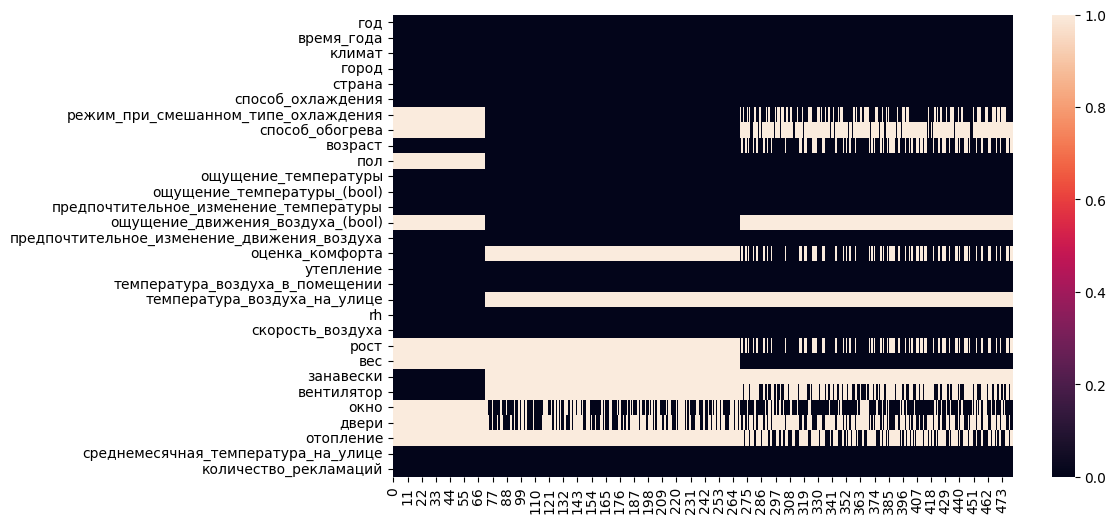

In [41]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.isna().T);

In [42]:
df.isna().mean()

год                                            0.000000
время_года                                     0.000000
климат                                         0.000000
город                                          0.000000
страна                                         0.000000
способ_охлаждения                              0.000000
режим_при_смешанном_типе_охлаждения            0.304979
способ_обогрева                                0.539419
возраст                                        0.143154
пол                                            0.149378
ощущение_температуры                           0.000000
ощущение_температуры_(bool)                    0.000000
предпочтительное_изменение_температуры         0.000000
ощущение_движения_воздуха_(bool)               0.589212
предпочтительное_изменение_движения_воздуха    0.000000
оценка_комфорта                                0.553942
утепление                                      0.000000
температура_воздуха_в_помещении                0

In [43]:
# Создадим разные датасеты для стран, так как мы выяснили,
# что эти группы независимы.
# Данные будем конкатенировать в конце после всей обработки и анализа.
df_au = df[df['страна'] == 'Австралия'].copy()
df_us = df[df['страна'] == 'США'].copy()
df_in = df[df['страна'] == 'Индия'].copy()

In [44]:
# Данные упорядочены по странам, поэтому можем на heatmap пронаблюдать пропуски
print(f'min/max индекс США: {np.min(df_us.index)}, {np.max(df_us.index)}')
print(f'min/max индекс Австралии: {np.min(df_au.index)}, {np.max(df_au.index)}')
print(f'min/max индекс Индии: {np.min(df_in.index)}, {np.max(df_in.index)}')

min/max индекс США: 0, 71
min/max индекс Австралии: 72, 269
min/max индекс Индии: 270, 481


### 1.4.1 Пропуски в отоплении

Будем опираться на условие о жаркой погоде. В жаркую летнюю погоду никто не будет включать отопление, если у нас нет информации о других возможных случаях.

**Доп**
> По сути нам не нужно знать про механическое отопление летом, так как эта информация нам будет только мешать. Заменим на Na. Аналогично для способа охлаждения сделаем зимой, когда включено отопление, так как это тоже мешающая для анализа данных лишняя информация.

In [45]:
target = 'отопление'

**Австралия**

In [46]:
df_au[target].isna().mean()

1.0

In [47]:
df_au[['город', 'климат']].value_counts(normalize=True)

город   климат                     
Сидней  Cубтропический океанический    1.0
dtype: float64

In [48]:
temp = df_au.groupby(['время_года', target], dropna=False).size()
temp = temp.to_frame()
display(temp)

,,0
время_года,отопление,
Лето,NaN,198


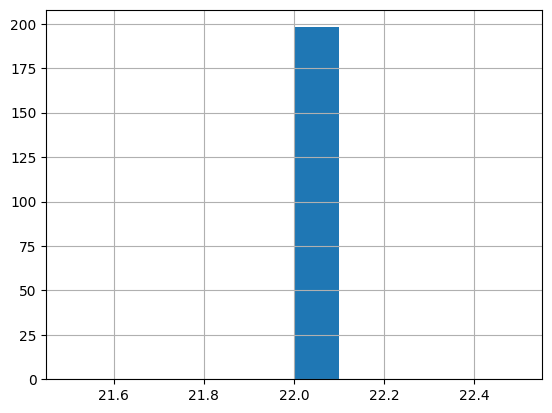

In [49]:
df_au['среднемесячная_температура_на_улице'].hist();

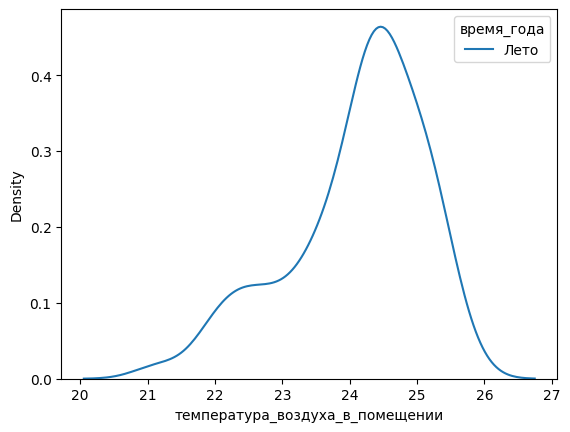

In [50]:
sns.kdeplot(data=df_au, x='температура_воздуха_в_помещении', hue='время_года');

In [51]:
# Цитата из интернета: "В Австралии отсутствует система центрального отопления.
# Даже в холодные месяцы на улице бывает теплее, чем в помещении."

# Отсюда делаем вывод, что отопление можно заполнить 0, потому что в 22 градуса
# летом в таком-то климате никто не будет включать отопление.

df_au[target] = df_au[target].fillna(0)

**США**

In [52]:
df_us[target].isna().mean()

1.0

In [53]:
df_us[['город', 'климат']].value_counts(normalize=True)

город  климат                     
Техас  Cубтропический океанический    1.0
dtype: float64

In [54]:
temp = df_us.groupby(['время_года', target], dropna=False).size()
temp = temp.to_frame()
display(temp)

,,0
время_года,отопление,
Лето,NaN,72


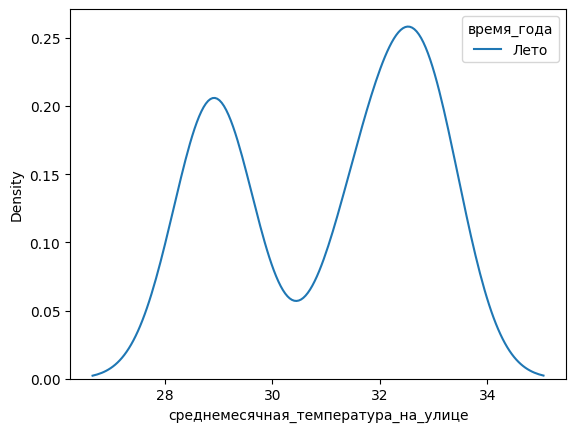

In [55]:
sns.kdeplot(df_us, x='среднемесячная_температура_на_улице', hue='время_года');

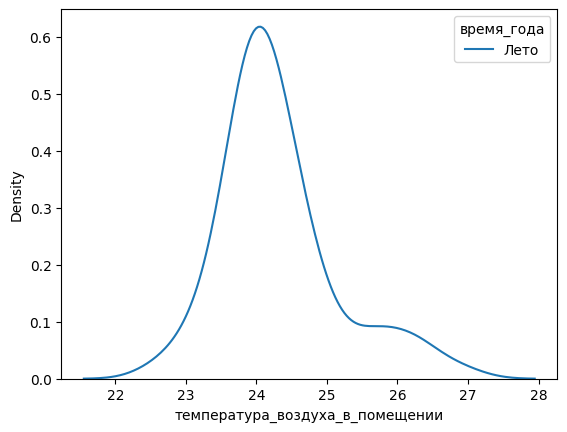

In [56]:
sns.kdeplot(data=df_us, x='температура_воздуха_в_помещении', hue='время_года');

In [57]:
# Ссылаемся на условие о том, что

# Способ обогрева:
# - NA = отсутствие механического отопления, неизвестно или
# исследование только в жаркую летнюю погоду.

# Здесь у нас точно жаркая летняя погода => заполняем 0 отопление

df_us[target] = df_us[target].fillna(0)

**Индия**

In [58]:
df_in[target].isna().mean()

0.6273584905660378

In [59]:
df_in[['город', 'климат']].value_counts(normalize=True)

город       климат                          
Ченнай      Тропическая влажная саванна         0.240566
Ахмедабад   Жаркий полузасушливый               0.179245
Дели        Влажный субтропический муссонный    0.165094
Шимла       Субтропическое высокогорье          0.150943
Хайдарабад  Жаркий полузасушливый               0.141509
Бангалор    Тропическая влажная саванна         0.122642
dtype: float64

In [60]:
df_in.corr(method='spearman')[target].sort_values()

окно                                  -0.449537
температура_воздуха_в_помещении       -0.373621
возраст                               -0.371307
ощущение_температуры                  -0.151127
вентилятор                            -0.107541
rh                                    -0.046603
ощущение_температуры_(bool)           -0.032661
скорость_воздуха                      -0.002030
количество_рекламаций                  0.095532
среднемесячная_температура_на_улице    0.131966
вес                                    0.174473
рост                                   0.193719
утепление                              0.222007
оценка_комфорта                        0.333208
отопление                              1.000000
ощущение_движения_воздуха_(bool)            NaN
температура_воздуха_на_улице                NaN
занавески                                   NaN
двери                                       NaN
Name: отопление, dtype: float64

In [61]:
df_in.groupby(['время_года', 'климат', target], dropna=False).agg(
    {'среднемесячная_температура_на_улице' : ['min'],
     'температура_воздуха_в_помещении' : ['median'],
     target: ['size']})

среднемесячная_температура_на_улице  \
                                                                                      min   
время_года климат                           отопление                                       
Весна      Жаркий полузасушливый            NaN                                      31.5   
           Тропическая влажная саванна      NaN                                      30.4   
Зима       Влажный субтропический муссонный 0.0                                      15.5   
                                            1.0                                      15.5   
                                            NaN                                      15.5   
           Жаркий полузасушливый            0.0                                      21.3   
                                            1.0                                      21.3   
                                            NaN                                      21.3   
           Субтропическое высокогорье       NaN                                       8.5   
           Тропическая влажная саванна      0.0                                      29.9   
                                            1.0                                      29.9   
                                            NaN                                      29.9   
Лето       Влажный субтропический муссонный 0.0                                      30.9   
                                            1.0                                      30.9   
                                            NaN                                      30.9   
           Жаркий полузасушливый            0.0                                      29.5   
                                            1.0                                      29.5   
                                            NaN                                      27.0   
           Субтропическое высокогорье       0.0                                      18.5   
                                            NaN                                      18.5   
           Тропическая влажная саванна      0.0                                      30.8   
                                            1.0                                      30.8   
                                            NaN                                      30.8   
Осень      Жаркий полузасушливый            NaN                                      25.7   
           Тропическая влажная саванна      NaN                                      29.7   

                                                      температура_воздуха_в_помещении  \
                                                                               median   
время_года климат                           отопление                                   
Весна      Жаркий полузасушливый            NaN                                 27.90   
           Тропическая влажная саванна      NaN                                 26.60   
Зима       Влажный субтропический муссонный 0.0                                 25.30   
                                            1.0                                 23.80   
                                            NaN                                 18.30   
           Жаркий полузасушливый            0.0                                 26.85   
                                            1.0                                 25.30   
                                            NaN                                 27.20   
           Субтропическое высокогорье       NaN                                 20.20   
           Тропическая влажная саванна      0.0                                 28.05   
                                            1.0                                 25.90   
                                            NaN                                 26.60   
Лето       Влажный субтропический муссонный 0.0                                 34.60   
                         

In [62]:
target = 'отопление'

df_in.loc[(df_in['время_года'] == 'Весна'), target] = 0

df_in.loc[(df_in['время_года'] == 'Зима') &
          (df_in['время_года'] == 'Влажный субтропический муссонный') &
          (df_in[target].isnull()), target] = 1

df_in.loc[(df_in['время_года'] == 'Зима') &
          (df_in['климат'] == 'Жаркий полузасушливый') &
          (df_in[target].isnull()), target] = 0

df_in.loc[(df_in['время_года'] == 'Зима') &
          (df_in['климат'] == 'Влажный субтропический муссонный') &
          (df_in[target].isnull()), target] = 1

df_in.loc[(df_in['время_года'] == 'Зима') &
          (df_in['климат'] == 'Субтропическое высокогорье') &
          (df_in[target].isnull()), target] = 1

df_in.loc[(df_in['время_года'] == 'Зима') &
          (df_in['климат'] == 'Тропическая влажная саванна') &
          (df_in[target].isnull()), target] = 0

df_in.loc[(df_in['время_года'] == 'Лето') &
          (df_in['климат'] == 'Влажный субтропический муссонный') &
          (df_in[target].isnull()), target] = 0

df_in.loc[(df_in['время_года'] == 'Лето') &
          (df_in['климат'] == 'Жаркий полузасушливый') &
          (df_in[target].isnull()), target] = 0

df_in.loc[(df_in['время_года'] == 'Лето') &
          (df_in['климат'] == 'Субтропическое высокогорье') &
          (df_in[target].isnull()), target] = 0

df_in.loc[(df_in['время_года'] == 'Лето') &
          (df_in['климат'] == 'Тропическая влажная саванна') &
          (df_in[target].isnull()), target] = 0

df_in.loc[(df_in['время_года'] == 'Осень') &
          (df_in['климат'] == 'Жаркий полузасушливый') &
          (df_in[target].isnull()), target] = 0

df_in.loc[(df_in['время_года'] == 'Осень') &
          (df_in['климат'] == 'Тропическая влажная саванна') &
          (df_in[target].isnull()), target] = 0

In [63]:
df_in.groupby(['время_года', 'климат', target], dropna=False).agg(
    {'среднемесячная_температура_на_улице' : ['min'],
     'температура_воздуха_в_помещении' : ['median'],
     target: ['size']})

среднемесячная_температура_на_улице  \
                                                                                      min   
время_года климат                           отопление                                       
Весна      Жаркий полузасушливый            0.0                                      31.5   
           Тропическая влажная саванна      0.0                                      30.4   
Зима       Влажный субтропический муссонный 0.0                                      15.5   
                                            1.0                                      15.5   
           Жаркий полузасушливый            0.0                                      21.3   
                                            1.0                                      21.3   
           Субтропическое высокогорье       1.0                                       8.5   
           Тропическая влажная саванна      0.0                                      29.9   
                                            1.0                                      29.9   
Лето       Влажный субтропический муссонный 0.0                                      30.9   
                                            1.0                                      30.9   
           Жаркий полузасушливый            0.0                                      27.0   
                                            1.0                                      29.5   
           Субтропическое высокогорье       0.0                                      18.5   
           Тропическая влажная саванна      0.0                                      30.8   
                                            1.0                                      30.8   
Осень      Жаркий полузасушливый            0.0                                      25.7   
           Тропическая влажная саванна      0.0                                      29.7   

                                                      температура_воздуха_в_помещении  \
                                                                               median   
время_года климат                           отопление                                   
Весна      Жаркий полузасушливый            0.0                                 27.90   
           Тропическая влажная саванна      0.0                                 26.60   
Зима       Влажный субтропический муссонный 0.0                                 25.30   
                                            1.0                                 22.85   
           Жаркий полузасушливый            0.0                                 26.90   
                                            1.0                                 25.30   
           Субтропическое высокогорье       1.0                                 20.20   
           Тропическая влажная саванна      0.0                                 26.70   
                                            1.0                                 25.90   
Лето       Влажный субтропический муссонный 0.0                                 35.80   
                                            1.0                                 24.40   
           Жаркий полузасушливый            0.0                                 29.40   
                                            1.0                                 25.50   
           Субтропическое высокогорье       0.0                                 22.40   
           Тропическая влажная саванна      0.0                                 27.30   
                                            1.0                                 25.30   
Осень      Жаркий полузасушливый            0.0                                 28.10   
           Тропическая влажная саванна      0.0                                 26.20   

                                                      отопление  
                                                           size  
время_года климат                           отопление            
Весна      Жаркий полузасушливый

In [64]:
df_in['время_года'].value_counts()

Лето     102
Зима      79
Весна     18
Осень     13
Name: время_года, dtype: int64

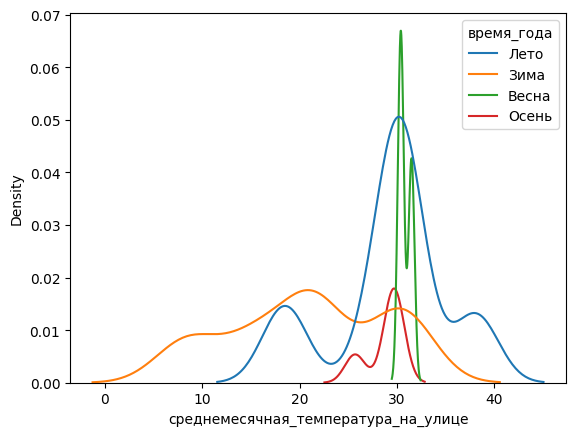

In [65]:
sns.kdeplot(data=df_in, x='среднемесячная_температура_на_улице', hue='время_года');

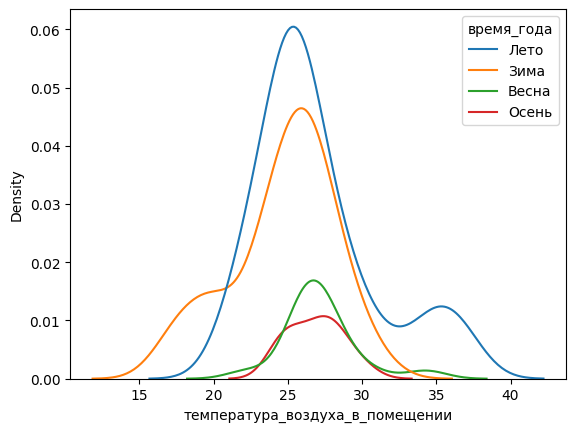

In [66]:
sns.kdeplot(data=df_in, x='температура_воздуха_в_помещении', hue='время_года');

In [67]:
df_in.loc[df_in[target] == 0, 'способ_обогрева'] = 'Не используется'
df_in.loc[df_in['способ_обогрева'].isna(), 'способ_обогрева'] = 'unknown'

### 1.4.2 Пропуски в способе обогрева

In [68]:
target = 'способ_обогрева'

**Австралия**

In [69]:
df_au.loc[df_au['отопление'] == 0, target] = 'Не используется'
df_au[target + '_nan'] = 0
df_au.loc[df_au[target].isna(), target + '_nan'] = 1
df_au.loc[df_au[target].isna(), target] = 'unknown'

**США**

In [70]:
df_us.loc[df_us['отопление'] == 0, target] = 'Не используется'
df_us[target + '_nan'] = 0
df_us.loc[df_us[target].isna(), target + '_nan'] = 1
df_us.loc[df_us[target].isna(), target] = 'unknown'

**Индия**

In [71]:
df_in.loc[df_in['отопление'] == 0, target] = 'Не используется'
df_in[target + '_nan'] = 0
df_in.loc[df_in[target].isna(), target + '_nan'] = 1
df_in.loc[df_in[target].isna(), target] = 'unknown'

### 1.4.3 Пропуски в возрасте

Попробуем найти корреляцию, по которой однозначно можно определить возраст.

In [72]:
target = 'возраст'

**Австралия**

In [73]:
df_au[target].isna().mean()

0.0

**США**

In [74]:
df_us[target].isna().mean()

0.0

**Индия**

In [75]:
df_in[target].isna().mean()

0.32547169811320753

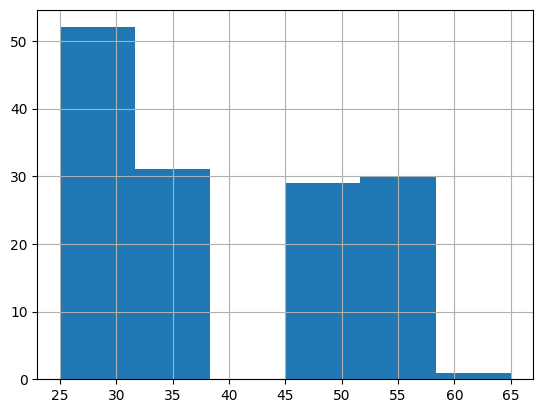

In [76]:
df_in['возраст'].hist(bins=6);

In [77]:
df_in['возраст'] = df_in.groupby(['город'])['возраст'].transform(
    lambda x: x.fillna(x.mean())
    )
df_in['возраст'] = df_in['возраст'].fillna(df_in['возраст'].median())

In [78]:
df_in['возраст'].isna().mean()

0.0

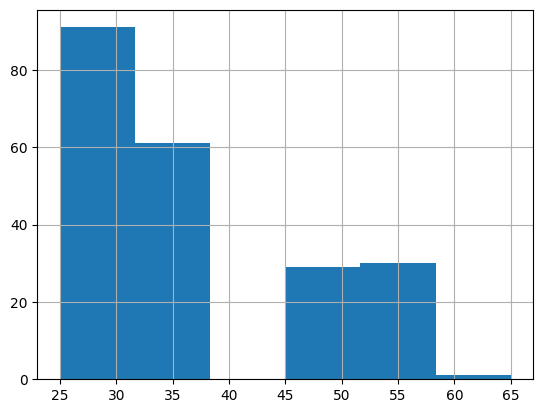

In [79]:
df_in['возраст'].hist(bins=6);

### 1.4.4 Пропуски в поле

In [80]:
target = 'пол'

**Австралия**

In [81]:
df_au[target].isna().mean()

0.0

**США**

In [82]:
df_us[target].isna().mean()

1.0

**Индия**

In [83]:
df_in[target].isna().mean()

0.0

### 1.4.5 Пропуски в ощущении движения воздуха (bool)

Будем заполнять пропуски, основываясь на предпочтительном изменении движения воздуха.

In [84]:
target = 'ощущение_движения_воздуха_(bool)'

**Австралия**

In [85]:
df_au[target].isna().mean()

0.0

**США**

In [86]:
df_us[target].isna().mean()

1.0

In [87]:
# Нет никаких данных по ощущению движения воздуха (bool) в США.
# Однако заполнить это возможно. Нужно посмотреть на то, хотят ли
# клиенты, чтобы движения воздуха изменилось. Если да, то заполним 0,
# если нет - 1 (устраивает).

col = 'предпочтительное_изменение_движения_воздуха'
df_us[target] = df_us[col].apply(
    lambda x: 1 if x == 'Без изменений' else 0
)

In [88]:
df_us[target].value_counts()

1    40
0    32
Name: ощущение_движения_воздуха_(bool), dtype: int64

In [89]:
# Можно проверить на примере Австралии, что это будет верно

corr, p_value = crammer_and_pvalue(df_au, target, col)

In [90]:
print(f'Корреляция: {round(corr, 2)}', f'p-value: {round(p_value, 4)}', sep='\n')

Корреляция: 0.91
p-value: 0.0


In [91]:
# Видим очень сильную взаимосвязь между этими факторами, причём этому выводу.
# можно доверять. Так как корреляция Краммера не показывает положительная связь
# или отрицательная, то сделаем groupby

t = df_au.groupby(col)[target].agg(['mean', 'count']).reset_index()
display(t)

,предпочтительное_изменение_движения_воздуха,mean,count
0,Без изменений,0.993056,144
1,Больше,0.111111,45
2,Меньше,0.111111,9


In [92]:
# Наблюдаем, что только каждый 9, кто хотел бы изменить движения воздуха всё
# равно считают приемлемым движения воздуха, которое есть сейчас. И более 99%,
# кто не хотел бы ничего менять в движении воздуха, всем довольны. Если "без
# изменений" мы сделали правильно, то вот вероятность того, что все 32 человека
# остались недовольны в США по схеме Бернулли равна все лишь 2%, если судить по
# полученным из Австралии вероятностям (они же mean). Поэтому воспользуемся
# биномиальным распределением, чтобы повысить достоверность данных.

In [93]:
index = df_us[df_us[col] != 'Без изменений'].index.to_list()
df_us.loc[index, target] = np.random.binomial(1, 1 / 9, size=len(index))

In [94]:
df_us[target].value_counts()

1    45
0    27
Name: ощущение_движения_воздуха_(bool), dtype: int64

In [95]:
df_us[target].isna().mean()

0.0

**Индия**

In [96]:
df_in[target].isna().mean()

1.0

In [97]:
# Нет никаких данных по ощущению движения воздуха (bool) в Индии.
# Поступаем аналогично, как и в случае с США.

In [98]:
df_in[target] = df_in[col].apply(lambda x: 1 if x == 'Без изменений' else 0)
index = df_in[df_in[col] != 'Без изменений'].index.to_list()
df_in.loc[index, target] = np.random.binomial(1, 1 / 9, size=len(index))

In [99]:
df_in[target].value_counts()

1    121
0     91
Name: ощущение_движения_воздуха_(bool), dtype: int64

In [100]:
df_in[target].isna().mean()

0.0

### 1.4.6 Пропуски в температуре воздуха на улице

Везде, где есть пропуски в температуре воздуха на улице, будем заменять на среднемесячную температуру в данном городе и сезоне.

In [101]:
target = 'температура_воздуха_на_улице'

**Австралия**

In [102]:
df_au[target].isna().mean()

1.0

In [103]:
# Нет никаких данных по температура на улице

In [104]:
df_au[['город', 'время_года']].value_counts(normalize=True)

город   время_года
Сидней  Лето          1.0
dtype: float64

In [105]:
# Так как по Австралии есть данные только по одному городу и только одному
# сезону, то подставляем полностью среднемесячную температуру на улице

df_au[target] = df_au['среднемесячная_температура_на_улице'].mean()

In [106]:
df_au[target].isna().mean()

0.0

**США**

In [107]:
df_us[target].isna().mean()

0.0

**Индия**

In [108]:
df_in[target].isna().mean()

1.0

In [109]:
df_in[['город', 'время_года']].value_counts(normalize=True)

город       время_года
Ахмедабад   Лето          0.122642
Дели        Лето          0.099057
Шимла       Лето          0.084906
Бангалор    Лето          0.075472
Ченнай      Лето          0.075472
Хайдарабад  Зима          0.070755
Дели        Зима          0.066038
Ченнай      Зима          0.066038
Шимла       Зима          0.066038
Ахмедабад   Зима          0.056604
Ченнай      Весна         0.051887
Бангалор    Зима          0.047170
Ченнай      Осень         0.047170
Хайдарабад  Весна         0.033019
            Лето          0.023585
            Осень         0.014151
dtype: float64

In [110]:
df_in[target] = df_in.groupby(['город', 'время_года'])['среднемесячная_температура_на_улице'].transform('mean')

In [111]:
df_in[target].isna().mean()

0.0

In [112]:
# Теперь данные по Индии заполнены.

### 1.4.7 Пропуски в росте и весе

In [113]:
target = ['рост', 'вес']

**Австралия**

In [114]:
df_au[target].isna().mean()

рост    1.0
вес     1.0
dtype: float64

In [115]:
# Данных по росту и весу в Австралии нет.

**США**

In [116]:
df_us[target].isna().mean()

рост    1.0
вес     1.0
dtype: float64

In [117]:
# Данных по росту и весу в США нет.

**Индия**

In [118]:
df_in[target].isna().mean()

рост    0.325472
вес     0.000000
dtype: float64

In [119]:
# Есть пропуски в данных по росту в Индии.

In [120]:
# Мы знаем, что в среднем девушки на 10 см ниже мужчин.
# Поэтому попробуем заменить, где это возможно, пропуски в росте
# на медианный рост по половому признаку в Индии.

df_in['рост'] = df_in.groupby('пол')['рост'].transform(lambda x: x.fillna(x.median()))

In [121]:
df_in[target].isna().mean()

рост    0.0
вес     0.0
dtype: float64

In [122]:
# Теперь данные по Индии заполнены.

### 1.4.8 Пропуски в занавесках, вентиляторах, окнах, дверях

In [123]:
target = ['занавески', 'вентилятор', 'окно', 'двери']

In [124]:
# Отследим корреляцию между факторами
result = []
for i, target_1 in enumerate(target[:-1]):
  for target_2 in target[i + 1:]:
    corr, p_value = crammer_and_pvalue(df, target_1, target_2)
    result.append([f'{target_1}_{target_2}', corr, p_value])
result = list(zip(*result))

result = pd.DataFrame(
    {'Колонки': result[0],
     'Корреляция': result[1],
     'p-value': result[2]}
    ).sort_values(by='p-value').reset_index(drop=True)
display(result)

,Колонки,Корреляция,p-value
0,занавески_вентилятор,0.97,0.0000
1,окно_двери,0.39,0.0000
2,вентилятор_окно,0.28,0.0591
3,занавески_окно,NaN,NaN
4,занавески_двери,NaN,NaN
5,вентилятор_двери,NaN,NaN


**Занавески**

In [125]:
# Данные по занавескам и вентилятору идеально коррелируют друг с другом
# Есть очень сильная связь занавесок и вентилятора.

df.groupby('занавески')['вентилятор'].mean()

занавески
0.0    0.0
1.0    1.0
Name: вентилятор, dtype: float64

In [126]:
# Если занавески открыты, то вентилятор человеку не нужен и наоборот.
# Если занавески закрывают окно, то значит, нужен вентилятор, т.к. человеку,
# скорее всего, душно. Проверим гипотезу о том, почему окна завешиваются, потому
# что человеку душно (по ощущению температуры)

sample_1 = df_us[df_us['занавески'] == 0]['ощущение_температуры']
sample_2 = df_us[df_us['занавески'] == 1]['ощущение_температуры']

p_value, method = numeric_hypothesis_test(sample_1, sample_2)
print(f'Метод: {method}', f'p-value: {p_value}', sep='\n')

Метод: Манн-Уитни
p-value: 0.4431


In [127]:
# Текущих данных не хватает, чтобы сделать вывод о различии средних.

**Вентилятор**

In [128]:
result = []
for col in df.select_dtypes(include='float64').columns:
  temp = df[(~df['вентилятор'].isnull()) & (~df[col].isnull())].copy().reset_index(drop=True)
  corr = correlation_ratio(temp['вентилятор'], temp[col])
  result.append([f'вентилятор_{col}', corr])
result = list(zip(*result))

result = pd.DataFrame(
    {'Колонки': result[0],
     'Корреляция': result[1]}
    ).sort_values(by='Корреляция', ascending=False).reset_index(drop=True)
display(result)

,Колонки,Корреляция
0,вентилятор_занавески,1.00
1,вентилятор_вентилятор,1.00
2,вентилятор_скорость_воздуха,0.48
3,вентилятор_температура_воздуха_на_улице,0.37
4,вентилятор_температура_воздуха_в_помещении,0.36
5,вентилятор_окно,0.32
6,вентилятор_среднемесячная_температура_на_улице,0.29
7,вентилятор_утепление,0.28
8,вентилятор_rh,0.27
9,вентилятор_оценка_комфорта,0.23


In [129]:
# Наиболее интересные связи это вентилятор_скорость_воздуха	, вентилятор_температура_воздуха_на_улице,
# вентилятор_температура_воздуха_в_помещении, вентилятор_окно, вентилятор_утепление	и вентилятор_rh
df.groupby('вентилятор')[['скорость_воздуха', 'температура_воздуха_на_улице',
                          'температура_воздуха_в_помещении', 'окно',
                          'утепление', 'rh']].mean().round(2)

,скорость_воздуха,температура_воздуха_на_улице,температура_воздуха_в_помещении,окно,утепление,rh
вентилятор,,,,,,
0.0,0.10,24.33,24.47,0.17,0.72,42.80
1.0,0.29,23.89,27.15,0.48,0.62,49.57


**Окно**

In [130]:
result = []
for col in df.select_dtypes(include='float64').columns:
  temp = df[(~df['окно'].isnull()) & (~df[col].isnull())].copy().reset_index(drop=True)
  corr = correlation_ratio(temp['окно'], temp[col])
  result.append([f'окно_{col}', corr])
result = list(zip(*result))

result = pd.DataFrame(
    {'Колонки': result[0],
     'Корреляция': result[1]}
    ).sort_values(by='Корреляция', ascending=False).reset_index(drop=True)
display(result)

,Колонки,Корреляция
0,окно_окно,1.00
1,окно_отопление,0.45
2,окно_двери,0.42
3,окно_вентилятор,0.32
4,окно_утепление,0.23
5,окно_rh,0.19
6,окно_температура_воздуха_в_помещении,0.15
7,окно_скорость_воздуха,0.15
8,окно_вес,0.13
9,окно_возраст,0.11


In [131]:
# Наиболее интересные связи это окно_отопление, окно_двери, окно_вентилятор,
# окно_утепление
df.groupby('окно')[['отопление', 'двери',
                     'вентилятор', 'утепление']].mean().round(2)

,отопление,двери,вентилятор,утепление
окно,,,,
0.0,0.71,0.12,0.39,0.70
1.0,0.14,0.67,0.73,0.55


**Двери**

In [132]:
# Больше всего вопросов возникает с дверьми. С чем они могут быть связаны ещё?
result = []
for col in df.select_dtypes(include='float64').columns:
  temp = df[(~df['двери'].isnull()) & (~df[col].isnull())].copy().reset_index(drop=True)
  corr = correlation_ratio(temp['двери'], temp[col])
  result.append([f'двери_{col}', corr])
result = list(zip(*result))

result = pd.DataFrame(
    {'Колонки': result[0],
     'Корреляция': result[1]}
    ).sort_values(by='Корреляция', ascending=False).reset_index(drop=True)
display(result)

,Колонки,Корреляция
0,двери_двери,1.00
1,двери_окно,0.42
2,двери_температура_воздуха_в_помещении,0.39
3,двери_rh,0.25
4,двери_вес,0.25
5,двери_ощущение_движения_воздуха_(bool),0.21
6,двери_утепление,0.14
7,двери_среднемесячная_температура_на_улице,0.11
8,двери_возраст,0.07
9,двери_ощущение_температуры,0.05


In [133]:
# Наиболее интересные связи это двери_окно, двери_температура_воздуха_в_помещении,
# двери_rh
df.groupby('двери')[['окно', 'температура_воздуха_в_помещении', 'rh']].mean().round(2)

,окно,температура_воздуха_в_помещении,rh
двери,,,
0.0,0.04,25.07,56.43
1.0,0.37,27.27,49.36


**Австралия**

In [134]:
df_au[target].isna().mean()

занавески     1.000000
вентилятор    1.000000
окно          0.414141
двери         0.565657
dtype: float64

In [135]:
# Данных по занавескам, вентиляторам в Австралии нет.

In [136]:
# Разберёмся с условием по системе охлаждения.

# Способ охлаждения:
# - Кондиционирование = может быть разных типов, окна закрыты.
# - Вентиляция = механические системы вентиляции и естественное охлаждение.
# - Смешанный = механическое охлаждение и окна открыты.
# - NA = неприменимо, например исследование холодной зимой, когда включено отопление.

df_au['способ_охлаждения'].value_counts(normalize=True)

Смешанный    1.0
Name: способ_охлаждения, dtype: float64

In [137]:
df_au.loc[df_au['способ_охлаждения']
          == 'Кондиционирование', 'окно'] = 1

df_au.loc[df_au['режим_при_смешанном_типе_охлаждения']
          == 'Кондиционирование', 'окно'] = 1

df_au['занавески'] = df_au['вентилятор']

In [138]:
df_au[target].isna().mean()

занавески     1.000000
вентилятор    1.000000
окно          0.101010
двери         0.565657
dtype: float64

**США**

In [139]:
df_us[target].isna().mean()

занавески     0.0
вентилятор    0.0
окно          1.0
двери         1.0
dtype: float64

In [140]:
# Нет информации по окнам и дверям. Окна мы можем заполнить.

df_us['способ_охлаждения'].value_counts(normalize=True)

Кондиционирование    1.0
Name: способ_охлаждения, dtype: float64

In [141]:
# Окна точно будут закрыты.

df_us['окно'] = 1

In [142]:
df_us[target].isna().mean()

занавески     0.0
вентилятор    0.0
окно          0.0
двери         1.0
dtype: float64

**Индия**

In [143]:
df_in[target].isna().mean()

занавески     1.000000
вентилятор    0.650943
окно          0.240566
двери         0.674528
dtype: float64

In [144]:
# Занавески можем заполнить, исходя из данных по вентилятору. Окно - исходя из
# системы охлаждения.

df_in['способ_охлаждения'].value_counts(normalize=True)

Смешанный            0.646226
Кондиционирование    0.198113
Вентиляция           0.155660
Name: способ_охлаждения, dtype: float64

In [145]:
for_replace = df_in[(df_in['способ_охлаждения'] == 'Кондиционирование') |
                     (df_in['режим_при_смешанном_типе_охлаждения']
                      == 'Кондиционирование')].index.to_list()
df_in.loc[for_replace, 'окно'] = 1
df_in['занавески'] = df_in['вентилятор']

In [146]:
df_in[target].isna().mean()

занавески     0.650943
вентилятор    0.650943
окно          0.042453
двери         0.674528
dtype: float64

In [147]:
# Насколько получилось заполнить, то заполнили

### 1.4.9 Пропуски в оценках комфорта

Предлагается вариант использования модели линейной регрессии для оценки комфорта клиента или Случайного леса



In [148]:
target = 'оценка_комфорта'

**Австралия**

In [149]:
df_au[target].isna().mean()

1.0

In [150]:
# Нет данных по Австралии.

**США**

In [151]:
df_us[target].isna().mean()

0.0

**Индия**

In [152]:
df_in[target].isna().mean()

0.32547169811320753

In [153]:
# В Индии 1/3 данных пропуски.

**Заполнение данных**

In [154]:
tmp = pd.concat([df_us, df_au, df_in])
tmp = tmp.dropna(subset=['оценка_комфорта'], axis=0)
tmp = tmp[tmp['отопление'] == 0]

In [155]:
tmp[tmp.select_dtypes(include='float64').columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134 entries, 0 to 479
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   возраст                              134 non-null    float64
 1   ощущение_температуры                 134 non-null    float64
 2   ощущение_температуры_(bool)          134 non-null    float64
 3   ощущение_движения_воздуха_(bool)     134 non-null    float64
 4   оценка_комфорта                      134 non-null    float64
 5   утепление                            134 non-null    float64
 6   температура_воздуха_в_помещении      134 non-null    float64
 7   температура_воздуха_на_улице         134 non-null    float64
 8   rh                                   134 non-null    float64
 9   скорость_воздуха                     134 non-null    float64
 10  рост                                 62 non-null     float64
 11  вес                             

In [156]:
numeric_columns = tmp.select_dtypes(include='float64').columns
corr = temp[numeric_columns].corr(method='spearman')
corr = corr[abs(corr) > 0.25]
corr = corr.dropna(thresh=2, axis=0)
corr = corr.dropna(how='all', axis=1)
display(corr)

,ощущение_температуры,ощущение_температуры_(bool),ощущение_движения_воздуха_(bool),утепление,температура_воздуха_в_помещении,rh,окно,двери,среднемесячная_температура_на_улице
ощущение_температуры,1.000000,-0.327859,-0.320406,NaN,NaN,NaN,NaN,NaN,NaN
ощущение_температуры_(bool),-0.327859,1.000000,0.442624,NaN,NaN,NaN,NaN,NaN,NaN
ощущение_движения_воздуха_(bool),-0.320406,0.442624,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
утепление,NaN,NaN,NaN,1.000000,0.599067,-0.533456,NaN,NaN,0.446308
температура_воздуха_в_помещении,NaN,NaN,NaN,0.599067,1.000000,-0.496531,NaN,0.326005,0.307540
rh,NaN,NaN,NaN,-0.533456,-0.496531,1.000000,NaN,NaN,-0.270804
окно,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.422819,NaN
двери,NaN,NaN,NaN,NaN,0.326005,NaN,0.422819,1.000000,NaN
среднемесячная_температура_на_улице,NaN,NaN,NaN,0.446308,0.307540,-0.270804,NaN,NaN,1.000000


In [157]:
def classification_reporter(data, target_col, numerics, categories):
  data = data.copy()
  data = data[numerics + categories + [target_col]]

  train = data[~data[target_col].isna()]
  predict_data = data[data[target_col].isna()]

  X = train.drop(columns=target_col)
  y = train[target_col]

  X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                      test_size=0.2,
                                                      random_state=32)

  ohe = OneHotEncoder(sparse_output=False, drop='first')

  def get_ohe(t, categ):
      temp = pd.DataFrame(data=ohe.transform(t[categ]), columns=ohe.get_feature_names_out())
      data = pd.concat([t.reset_index(drop=True), temp], axis=1)
      data = data.drop(columns=categ, axis=1)
      return data

  ohe.fit(X_train[categories])
  X_train = get_ohe(X_train, categories)
  X_test = get_ohe(X_test, categories)

  scaler = StandardScaler()
  scaler.fit(X_train[numerics])
  X_train[numerics] = scaler.transform(X_train[numerics])
  X_test[numerics] = scaler.transform(X_test[numerics])

  model = RandomForestClassifier(n_estimators=60, max_depth=100)
  model.fit(X_train, y_train)

  pred_train = model.predict(X_train)
  pred_test = model.predict(X_test)

  print('classification_report на train:')
  print(classification_report(y_train, pred_train))
  print('classification_report на test:')
  print(classification_report(y_test, pred_test))

In [158]:
features_numeric = ['ощущение_температуры_(bool)', 'ощущение_движения_воздуха_(bool)',
                    'утепление', 'температура_воздуха_в_помещении',
                    'ощущение_температуры', 'rh', 'скорость_воздуха']
features_categories = ['время_года', 'климат', 'способ_охлаждения']

classification_reporter(tmp, target, features_numeric, features_categories)

classification_report на train:
              precision    recall  f1-score   support

         2.0       1.00      1.00      1.00        10
         3.0       1.00      1.00      1.00        12
         4.0       1.00      1.00      1.00        22
         5.0       1.00      1.00      1.00        26
         6.0       1.00      1.00      1.00        37

    accuracy                           1.00       107
   macro avg       1.00      1.00      1.00       107
weighted avg       1.00      1.00      1.00       107

classification_report на test:
              precision    recall  f1-score   support

         2.0       0.33      0.50      0.40         4
         3.0       0.00      0.00      0.00         4
         4.0       0.57      0.50      0.53         8
         5.0       0.14      0.20      0.17         5
         6.0       0.67      0.67      0.67         6

    accuracy                           0.41        27
   macro avg       0.34      0.37      0.35        27
weighted avg  

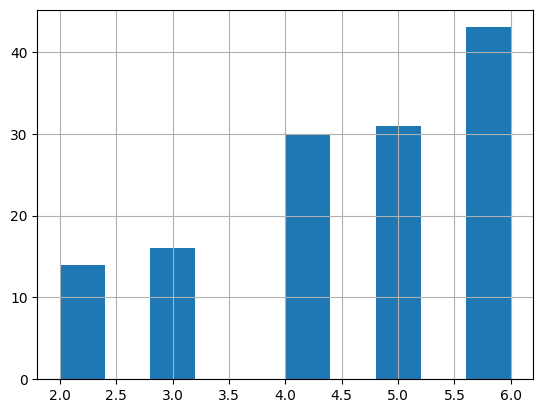

In [159]:
tmp['оценка_комфорта'].hist();

In [160]:
# Модель явно переобучается, а ещё катострофически не хватает данных, чтобы
# на их основании заполнять пропуски в оценке комфорта. precision и recall крайне
# малы. Классы не сбалансированы

### Вывод

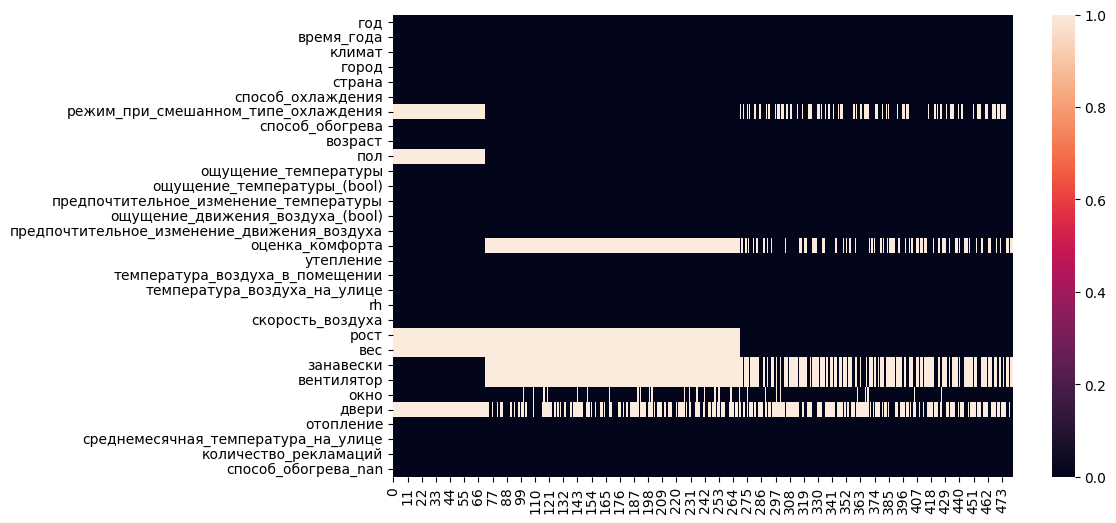

In [161]:
plt.figure(figsize=(10, 6))
sns.heatmap(pd.concat([df_us, df_au, df_in]).isna().T);

## 1.5 Объединение данных/проверка качества новых данных/удаление ненужных данных

In [162]:
df = pd.concat([df_au, df_us, df_in])

In [163]:
df = df.drop_duplicates().reset_index(drop=True)
df = df.drop(['рост', 'вес', 'вентилятор', 'занавески', 'двери'], axis=1)

In [164]:
# приводим объекты к категории
for col in df.select_dtypes(include='object').columns:
  df[col] = df[col].astype('category')

In [165]:
check_data(df)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 482 entries, 0 to 481
Data columns (total 26 columns):
 #   Column                                       Non-Null Count  Dtype         
---  ------                                       --------------  -----         
 0   год                                          482 non-null    datetime64[ns]
 1   время_года                                   482 non-null    category      
 2   климат                                       482 non-null    category      
 3   город                                        482 non-null    category      
 4   страна                                       482 non-null    category      
 5   способ_охлаждения                            482 non-null    category      
 6   режим_при_смешанном_типе_охлаждения          335 non-null    category      
 7   способ_обогрева                              482 non-null    category      
 8   возраст                                      482 non-null

,год,время_года,климат,город,страна,способ_охлаждения,режим_при_смешанном_типе_охлаждения,способ_обогрева,возраст,пол,ощущение_температуры,ощущение_температуры_(bool),предпочтительное_изменение_температуры,ощущение_движения_воздуха_(bool),предпочтительное_изменение_движения_воздуха,оценка_комфорта,утепление,температура_воздуха_в_помещении,температура_воздуха_на_улице,rh,скорость_воздуха,окно,отопление,среднемесячная_температура_на_улице,количество_рекламаций,способ_обогрева_nan
0,2010-01-01,Лето,Cубтропический океанический,Сидней,Австралия,Смешанный,Кондиционирование,Не используется,55.0,Женский,-1.0,0.0,Теплее,0.0,Меньше,NaN,0.54,24.4,22.0,56.1,0.18,1.0,0.0,22.0,0,0
1,2010-01-01,Лето,Cубтропический океанический,Сидней,Австралия,Смешанный,Кондиционирование,Не используется,55.0,Женский,0.0,1.0,Без изменений,1.0,Без изменений,NaN,0.59,25.3,22.0,74.0,0.04,1.0,0.0,22.0,0,0
2,2010-01-01,Лето,Cубтропический океанический,Сидней,Австралия,Смешанный,Кондиционирование,Не используется,55.0,Мужской,1.0,1.0,Без изменений,1.0,Без изменений,NaN,0.43,25.7,22.0,60.7,0.14,1.0,0.0,22.0,0,0
3,2010-01-01,Лето,Cубтропический океанический,Сидней,Австралия,Смешанный,Кондиционирование,Не используется,25.0,Женский,0.0,1.0,Без изменений,1.0,Без изменений,NaN,0.43,24.5,22.0,56.8,0.11,1.0,0.0,22.0,0,0
4,2010-01-01,Лето,Cубтропический океанический,Сидней,Австралия,Смешанный,Кондиционирование,Не используется,35.0,Мужской,3.0,0.0,Холоднее,0.0,Больше,NaN,0.46,25.7,22.0,64.1,0.12,1.0,0.0,22.0,0,0
5,2010-01-01,Лето,Cубтропический океанический,Сидней,Австралия,Смешанный,Кондиционирование,Не используется,45.0,Мужской,1.0,1.0,Без изменений,1.0,Без изменений,NaN,0.52,24.7,22.0,58.0,0.09,1.0,0.0,22.0,0,0
6,2010-01-01,Лето,Cубтропический океанический,Сидней,Австралия,Смешанный,Кондиционирование,Не используется,35.0,Мужской,0.0,1.0,Без изменений,1.0,Без изменений,NaN,0.46,24.6,22.0,76.6,0.07,1.0,0.0,22.0,0,0
7,2010-01-01,Лето,Cубтропический океанический,Сидней,Австралия,Смешанный,Кондиционирование,Не используется,35.0,Мужской,0.0,1.0,Без изменений,1.0,Без изменений,NaN,0.46,24.2,22.0,62.5,0.07,1.0,0.0,22.0,0,0
8,2010-01-01,Лето,Cубтропический океанический,Сидней,Австралия,Смешанный,Кондиционирование,Не используется,55.0,Женский,0.0,1.0,Без изменений,1.0,Без изменений,NaN,0.39,25.2,22.0,64.4,0.07,1.0,0.0,22.0,0,0
9,2010-01-01,Лето,Cубтропический океанический,Сидней,Австралия,Смешанный,Кондиционирование,Не используется,55.0,Женский,2.0,0.0,Холоднее,0.0,Больше,NaN,0.39,24.8,22.0,55.5,0.08,1.0,0.0,22.0,0,0



Описание количественных данных:


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
год,482,3,2012-01-01,212,2010-01-01,2012-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
возраст,482.0,NaN,NaT,NaN,NaT,NaT,39.360996,10.655782,22.0,30.833333,35.0,45.0,65.0
ощущение_температуры,482.0,NaN,NaT,NaN,NaT,NaT,0.208299,1.091478,-3.0,0.0,0.0,1.0,3.0
ощущение_температуры_(bool),482.0,NaN,NaT,NaN,NaT,NaT,0.788382,0.40888,0.0,1.0,1.0,1.0,1.0
ощущение_движения_воздуха_(bool),482.0,NaN,NaT,NaN,NaT,NaT,0.653527,0.47634,0.0,0.0,1.0,1.0,1.0
оценка_комфорта,215.0,NaN,NaT,NaN,NaT,NaT,4.767442,1.268549,1.0,4.0,5.0,6.0,6.0
утепление,482.0,NaN,NaT,NaN,NaT,NaT,0.632261,0.251936,0.36,0.46,0.59,0.7,2.08
температура_воздуха_в_помещении,482.0,NaN,NaT,NaN,NaT,NaT,25.004979,2.765908,16.2,23.8,24.6,25.7,37.4
температура_воздуха_на_улице,482.0,NaN,NaT,NaN,NaT,NaT,24.175519,5.360732,8.5,22.0,22.0,29.5,38.1
rh,482.0,NaN,NaT,NaN,NaT,NaT,53.019295,13.044019,23.8,42.85,53.85,62.375,85.1



Описание категориальных данных:


,count,unique,top,freq
время_года,482,4,Лето,372
климат,482,5,Cубтропический океанический,270
город,482,8,Сидней,198
страна,482,3,Индия,212
способ_охлаждения,482,3,Смешанный,335
режим_при_смешанном_типе_охлаждения,335,2,Кондиционирование,235
способ_обогрева,482,3,Не используется,401
пол,410,2,Мужской,254
предпочтительное_изменение_температуры,482,3,Без изменений,288
предпочтительное_изменение_движения_воздуха,482,3,Без изменений,291



Вывод уникальных значений по каждому признаку:
год


2010-01-01    198
2011-01-01     72
2012-01-01    212
Name: год, dtype: int64

время_года


Весна     18
Зима      79
Лето     372
Осень     13
Name: время_года, dtype: int64

климат


Cубтропический океанический         270
Влажный субтропический муссонный     35
Жаркий полузасушливый                68
Субтропическое высокогорье           32
Тропическая влажная саванна          77
Name: климат, dtype: int64

город


Ахмедабад      38
Бангалор       26
Дели           35
Сидней        198
Техас          72
Хайдарабад     30
Ченнай         51
Шимла          32
Name: город, dtype: int64

страна


Австралия    198
Индия        212
США           72
Name: страна, dtype: int64

способ_охлаждения


Вентиляция            33
Кондиционирование    114
Смешанный            335
Name: способ_охлаждения, dtype: int64

режим_при_смешанном_типе_охлаждения


Вентиляция           100
Кондиционирование    235
Name: режим_при_смешанном_типе_охлаждения, dtype: int64

способ_обогрева


unknown                    70
Механическое отопление     11
Не используется           401
Name: способ_обогрева, dtype: int64

возраст


22.000000     2
23.000000     1
25.000000    67
26.000000     4
27.000000     3
28.000000     3
29.000000     3
30.000000     3
30.833333    39
31.000000     3
32.000000     4
32.916667    30
34.000000     5
35.000000    91
36.000000     3
37.000000     1
38.000000     5
39.000000     4
40.000000     2
41.000000     1
42.000000     3
43.000000     5
45.000000    99
46.000000     4
48.000000     1
50.000000     2
51.000000     3
52.000000     1
55.000000    77
58.000000     1
65.000000    12
Name: возраст, dtype: int64

пол


Женский    156
Мужской    254
Name: пол, dtype: int64

ощущение_температуры


-3.0      1
-2.0     22
-1.5      1
-1.4      1
-1.3      1
-1.0     66
-0.5     10
-0.4      2
-0.2      1
-0.1      1
 0.0    225
 0.2      1
 0.5      6
 0.6      1
 0.8      2
 1.0     79
 1.1      5
 1.2      3
 1.5      2
 1.6      2
 2.0     26
 3.0     24
Name: ощущение_температуры, dtype: int64

ощущение_температуры_(bool)


0.0    102
1.0    380
Name: ощущение_температуры_(bool), dtype: int64

предпочтительное_изменение_температуры


Без изменений    288
Теплее            60
Холоднее         134
Name: предпочтительное_изменение_температуры, dtype: int64

ощущение_движения_воздуха_(bool)


0.0    167
1.0    315
Name: ощущение_движения_воздуха_(bool), dtype: int64

предпочтительное_изменение_движения_воздуха


Без изменений    291
Больше           159
Меньше            32
Name: предпочтительное_изменение_движения_воздуха, dtype: int64

оценка_комфорта


1.0     1
2.0    14
3.0    23
4.0    40
5.0    55
6.0    82
Name: оценка_комфорта, dtype: int64

утепление


0.36     2
0.37     6
0.38     4
0.39    18
0.40     7
0.41    18
0.42     7
0.43    17
0.44     3
0.45     1
0.46    64
0.47     1
0.48     1
0.49     4
0.50     5
0.51     1
0.52    10
0.53     5
0.54    11
0.55    11
0.56     3
0.57    37
0.58     3
0.59     7
0.60     2
0.61    33
0.62    10
0.63     8
0.64    12
0.65     1
0.66     5
0.67     8
0.68    27
0.69     2
0.70    19
0.71     5
0.72    13
0.73     4
0.74    12
0.75     6
0.77     1
0.78     5
0.79     4
0.80     1
0.81     2
0.82     1
0.83     1
0.84     7
0.85     1
0.86     1
0.87     1
0.88     1
0.90     2
0.91     1
0.92     3
0.93     1
0.94     1
0.96     2
0.97     6
1.00     1
1.02     1
1.03     1
1.04     1
1.11     1
1.12     2
1.19     1
1.22     1
1.32     1
1.40     1
1.41     1
1.44     1
1.45     2
1.47     1
1.48     1
1.59     1
1.67     1
1.68     1
1.69     1
1.74     2
1.75     1
1.83     1
2.06     1
2.08     1
Name: утепление, dtype: int64

температура_воздуха_в_помещении


16.2     1
17.0     1
17.5     1
17.6     1
18.0     1
18.3     1
18.7     1
18.9     1
19.4     1
20.0     1
20.2     3
20.4     1
20.5     1
20.6     1
21.1     3
21.3     1
21.4     1
21.6     1
21.7     1
21.8     3
21.9     5
22.0     2
22.1     3
22.2     3
22.3     4
22.4     3
22.5     4
22.6     4
22.7     3
22.8     2
22.9     7
23.0     2
23.1     6
23.2     6
23.3     5
23.4     4
23.5     8
23.6     9
23.7    10
23.8    14
23.9    10
24.0    14
24.1    16
24.2    15
24.3    19
24.4    20
24.5    16
24.6    14
24.7    13
24.8    12
24.9     8
25.0    13
25.1    12
25.2    15
25.3    13
25.4     9
25.5     4
25.6     4
25.7     8
25.8     7
25.9     3
26.0     4
26.1     6
26.2     2
26.3     6
26.4     2
26.5     2
26.6     5
26.7     4
26.8     3
26.9     4
27.0     2
27.1     2
27.2     1
27.3     2
27.5     7
27.6     2
27.7     2
27.8     2
27.9     3
28.0     1
28.1     2
28.2     3
28.3     1
28.4     1
28.6     1
28.7     2
28.8     2
28.9     1
29.2     1
29.3     2

температура_воздуха_на_улице


8.5      14
15.5     14
18.5     18
21.3     12
21.6     15
22.0    198
22.8      1
22.9      1
23.0      3
23.1      1
23.3      1
23.4      1
23.6      4
23.7      3
23.8      6
23.9      8
24.0      6
24.1     10
24.2      6
24.3      2
24.4      2
24.5      2
24.6      2
24.7      3
24.8      2
24.9      2
25.0      1
25.1      1
25.2      1
25.5      2
25.7      3
25.9      1
27.0      5
29.5     26
29.7     10
29.9     10
30.4     11
30.8     30
30.9     21
31.5      7
38.1     16
Name: температура_воздуха_на_улице, dtype: int64

rh


23.8    1
23.9    1
26.3    1
26.5    1
26.6    1
26.8    1
27.0    1
27.7    1
27.8    1
28.3    1
28.8    1
28.9    1
30.0    1
30.1    1
30.8    1
31.0    2
31.2    2
31.5    1
31.7    1
32.0    1
32.1    1
32.2    1
33.0    1
33.1    1
33.3    1
33.4    1
34.0    3
34.1    2
34.2    1
34.3    1
34.4    1
34.5    2
34.6    1
34.7    2
34.8    2
34.9    2
35.0    2
35.1    1
35.3    2
35.6    1
35.7    1
35.8    2
35.9    1
36.0    4
36.4    1
36.8    1
36.9    1
37.4    1
37.6    3
37.9    2
38.0    2
38.1    1
38.2    1
38.3    1
38.4    3
38.5    1
38.7    1
38.9    1
39.0    1
39.1    1
39.2    4
39.4    2
39.5    2
39.6    1
39.8    1
40.0    6
40.1    1
40.2    1
40.4    1
40.8    1
41.0    4
41.3    1
41.4    1
41.8    1
42.0    3
42.1    2
42.2    3
42.3    1
42.6    1
42.7    1
42.8    2
43.0    2
43.1    1
43.2    1
43.5    2
43.6    2
43.7    1
43.8    2
43.9    2
44.0    3
44.1    1
44.2    1
44.3    2
44.5    1
44.6    1
44.8    1
44.9    1
45.0    2
45.1    2
45.2    2


скорость_воздуха


0.00     4
0.01    13
0.02    21
0.03    18
0.04    19
0.05    20
0.06    25
0.07    37
0.08    48
0.09    34
0.10    24
0.11    42
0.12    26
0.13    28
0.14    15
0.15     7
0.16    11
0.17     6
0.18     8
0.19     6
0.20     3
0.21     9
0.22     5
0.23     3
0.24     1
0.25     2
0.26     2
0.27     1
0.28     2
0.29     1
0.31     4
0.32     7
0.33     3
0.34     3
0.35     1
0.36     1
0.38     1
0.39     1
0.40     1
0.41     2
0.45     1
0.47     1
0.48     1
0.50     2
0.53     1
0.54     1
0.56     1
0.57     1
0.60     1
0.65     1
0.77     1
0.82     1
1.00     1
1.23     1
1.42     1
1.43     1
Name: скорость_воздуха, dtype: int64

окно


0.0     65
1.0    388
Name: окно, dtype: int64

отопление


0.0    401
1.0     81
Name: отопление, dtype: int64

среднемесячная_температура_на_улице


8.5      14
15.5     14
18.5     18
21.3     12
21.6     15
22.0    198
25.7      3
27.0      5
28.9     27
29.4      1
29.5     26
29.7     10
29.9     10
30.4     11
30.8     30
30.9     21
31.5      7
31.7     16
32.8     28
38.1     16
Name: среднемесячная_температура_на_улице, dtype: int64

количество_рекламаций


0    448
1     24
2      3
3      7
Name: количество_рекламаций, dtype: int64

способ_обогрева_nan


0    482
Name: способ_обогрева_nan, dtype: int64

In [166]:
df = df.drop(['способ_обогрева_nan'], axis=1)

# 2. Проведение расчётов и исследований

## 2.1 Расчёты

In [167]:
col = 'количество_рекламаций_категория'
df[col] = df['количество_рекламаций'].apply(
    lambda x:
    'мало' if x <= 1
    else 'средне' if x == 2
    else 'много'
    )
df[col] = df[col].astype('category')

In [168]:
col = 'возрастная_категория'
df[col] = df['возраст'].apply(
    lambda x:
    'молодой возраст' if x <= 44
    else 'средний возраст' if x <= 59
    else 'пожилой возраст'
    )
df[col] = df[col].astype('category')

In [169]:
# Рассчитать среднюю комфортную температуру в зависимости от возрастной категории
df[df['ощущение_температуры_(bool)'] == 1].groupby('возрастная_категория').agg({
    'температура_воздуха_в_помещении': 'mean'
    }).round(1)

,температура_воздуха_в_помещении
возрастная_категория,
молодой возраст,25.2
пожилой возраст,25.4
средний возраст,24.1


In [170]:
# Средний возраст респондентов по полу и стране
df.groupby(['пол', 'страна']).agg({'возраст': 'mean'}).round(0)

возраст
пол     страна            
Женский Австралия     46.0
        Индия         35.0
        США            NaN
Мужской Австралия     43.0
        Индия         36.0
        США            NaN

In [171]:
# Рассчитать медианное значение температуры и влажности для каждого типа охлаждения
df.groupby(['способ_охлаждения']).agg({
    'температура_воздуха_в_помещении': 'median',
     'rh': 'median'
     })

,температура_воздуха_в_помещении,rh
способ_охлаждения,,
Вентиляция,25.3,46.30
Кондиционирование,24.3,42.45
Смешанный,24.6,56.50


In [172]:
# Добавить столбец с процентом удовлетворенных респондентов температурой воздуха
# в помещении относительно всех респондентов одной страны и одного пола
df['процент_удовлетворенных_температурой'] =\
 (df.groupby(['страна', 'пол'])['ощущение_температуры_(bool)'].transform('mean') * 100).round(2)

In [173]:
# Составить сводную таблицу, в которой данные будут сгруппированы по стране,
# полу, возрастной группе и посчитаны средняя температура воздуха в помещении,
# на улице и средняя относительная влажность для каждой из этих групп.
index=['страна', 'пол', 'возрастная_категория']
values=['температура_воздуха_в_помещении', 'температура_воздуха_на_улице', 'rh']
pd.pivot_table(df, index=index, values=values, aggfunc='mean').round(2)

rh  \
страна    пол     возрастная_категория          
Австралия Женский молодой возраст       61.37   
                  пожилой возраст       44.55   
                  средний возраст       61.27   
          Мужской молодой возраст       61.67   
                  пожилой возраст       64.37   
                  средний возраст       61.68   
Индия     Женский молодой возраст       49.89   
                  средний возраст       49.94   
          Мужской молодой возраст       49.54   
                  пожилой возраст       78.80   
                  средний возраст       52.76   

                                        температура_воздуха_в_помещении  \
страна    пол     возрастная_категория                                    
Австралия Женский молодой возраст                                 23.84   
                  пожилой возраст                                 24.90   
                  средний возраст                                 24.11   
          Мужской молодой возраст                                 24.15   
                  пожилой возраст                                 24.73   
                  средний возраст                                 24.04   
Индия     Женский молодой возраст                                 26.67   
                  средний возраст                                 24.23   
          Мужской молодой возраст                                 25.98   
                  пожилой возраст                                 29.30   
                  средний возраст                                 26.19   

                                        температура_воздуха_на_улице  
страна    пол     возрастная_категория                                
Австралия Женский молодой возраст                              22.00  
                  пожилой возраст                              22.00  
                  средний возраст                              22.00  
          Мужской молодой возраст                              22.00  
                  пожилой возраст                              22.00  
                  средний возраст                              22.00  
Индия     Женский молодой возраст                              27.99  
                  средний возраст                              21.83  
          Мужской молодой возраст                              27.45  
                  пожилой возраст                              29.50  
                  средний возраст                              22.81

In [174]:
# Самостоятельно найти информацию по стандартной комфортной относительной
# влажности в помещениях (в нашем случае - офисы). Создать новый категориальный
# столбец, в котором будет показано, удовлетворяет ли зафиксированная
# относительная влажность стандарту или нет. Категории назначить самостоятельно.
col = 'влажность_в_офисе_категория'
df[col] = df['rh'].apply(
    lambda x:
    'сухо' if x <= 20
    else 'удовлетворительно' if x < 40
    else 'рекомендуемая' if 40 <= x <= 60
    else 'удовлетворительно' if x < 70
    else 'сыро'
    )
df[col] = df[col].astype('category')

https://oborona.media/microclimate-at-work/

## 2.2 Исследование корреляции между параметрами



In [175]:
# рассчитать значение корреляции между всеми переменнными в датасете
# поскольку в датасете присутствует значения разных типов, то мы будем считать
# корреляции для 3 случаев:
# 1) Количественная - количественная - корреляция Пирсона/Спирмена
# 2) Категориальная - количественная - корреляция Eta
# 3) Категориальная - категориальная - коэффициент Крамера

# перед этим проверим на нормально количественные признаки в датасете

In [176]:
def check_normality_shapiro(df):
    normality_results = {}
    for column in df.select_dtypes(include=['int', 'float']):
        _, p_value = shapiro(df[column])
        normality_results[column] = p_value

    normality_results = pd.DataFrame(list(normality_results.values()),
                                     index=normality_results.keys())

    return normality_results

In [177]:
print(check_normality_shapiro(df).round(3))

                                          0
возраст                               0.000
ощущение_температуры                  0.000
ощущение_температуры_(bool)           0.000
ощущение_движения_воздуха_(bool)      0.000
оценка_комфорта                       1.000
утепление                             0.000
температура_воздуха_в_помещении       0.000
температура_воздуха_на_улице          0.000
rh                                    0.001
скорость_воздуха                      0.000
окно                                  1.000
отопление                             0.000
среднемесячная_температура_на_улице   0.000
количество_рекламаций                 0.000
процент_удовлетворенных_температурой  1.000


In [178]:
# видно, что данные распределены ненормально для всех колонок
# колонки с результатом 1 недостоверны, поскольку данные в них
# также разделены на категории (0 или 1) и т.д.
# поэтому для всех корреляция с количественными шкалами будем использовать
# корреляцию Спирмена

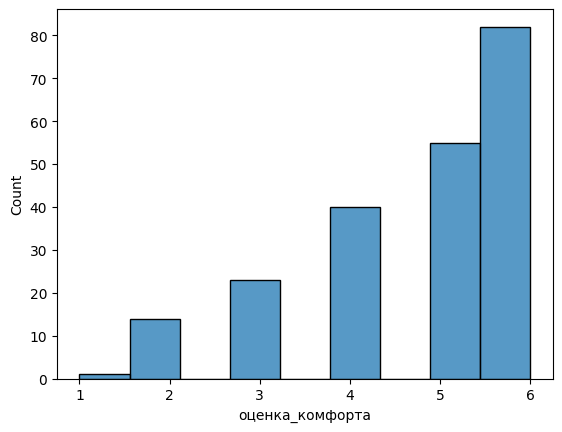

In [179]:
sns.histplot(data=df, x='оценка_комфорта');

In [180]:
df = df.drop('год', axis=1)

In [181]:
from scipy.stats import spearmanr, chi2_contingency

def calculate_correlation_matrix(df):
    corr_df = pd.DataFrame(index=df.columns, columns=df.columns)

    for column1 in df.columns:
        for column2 in df.columns:
          if column1 == column2:
            corr_df.loc[column1, column2] = 1.0
          else:
            if (df[column1].dtype in ('object', 'category')) and (df[column2].dtype in ('object', 'category')):
              corr_df.loc[column1, column2] = crammer_and_pvalue(df, column1, column2)[0]

            elif (df[column1].dtype in ('int64', 'float64')) and (df[column2].dtype in ('int64', 'float64')):
              corr = df[[column1, column2]].corr(method='spearman').iloc[0, 1]
              corr_df.loc[column1, column2] = corr
            else:
              if df[column1].dtype in ('object', 'category'):
                corr_df.loc[column1, column2] = correlation_ratio(df[column1], df[column2])
              elif df[column2].dtype in ('object', 'category'):
                corr_df.loc[column1, column2] = correlation_ratio(df[column2], df[column1])

    for col in corr_df.columns:
      corr_df[col] = corr_df[col].astype('float64')
    return corr_df

In [182]:
corr_df = calculate_correlation_matrix(df)

In [183]:
filt_corr_df = corr_df[corr_df.abs() >= 0.1]

In [184]:
filt_corr_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28 entries, время_года to влажность_в_офисе_категория
Data columns (total 28 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   время_года                                   22 non-null     float64
 1   климат                                       26 non-null     float64
 2   город                                        26 non-null     float64
 3   страна                                       24 non-null     float64
 4   способ_охлаждения                            21 non-null     float64
 5   режим_при_смешанном_типе_охлаждения          9 non-null      float64
 6   способ_обогрева                              19 non-null     float64
 7   возраст                                      18 non-null     float64
 8   пол                                          7 non-null      float64
 9   ощущение_температуры                         15 n

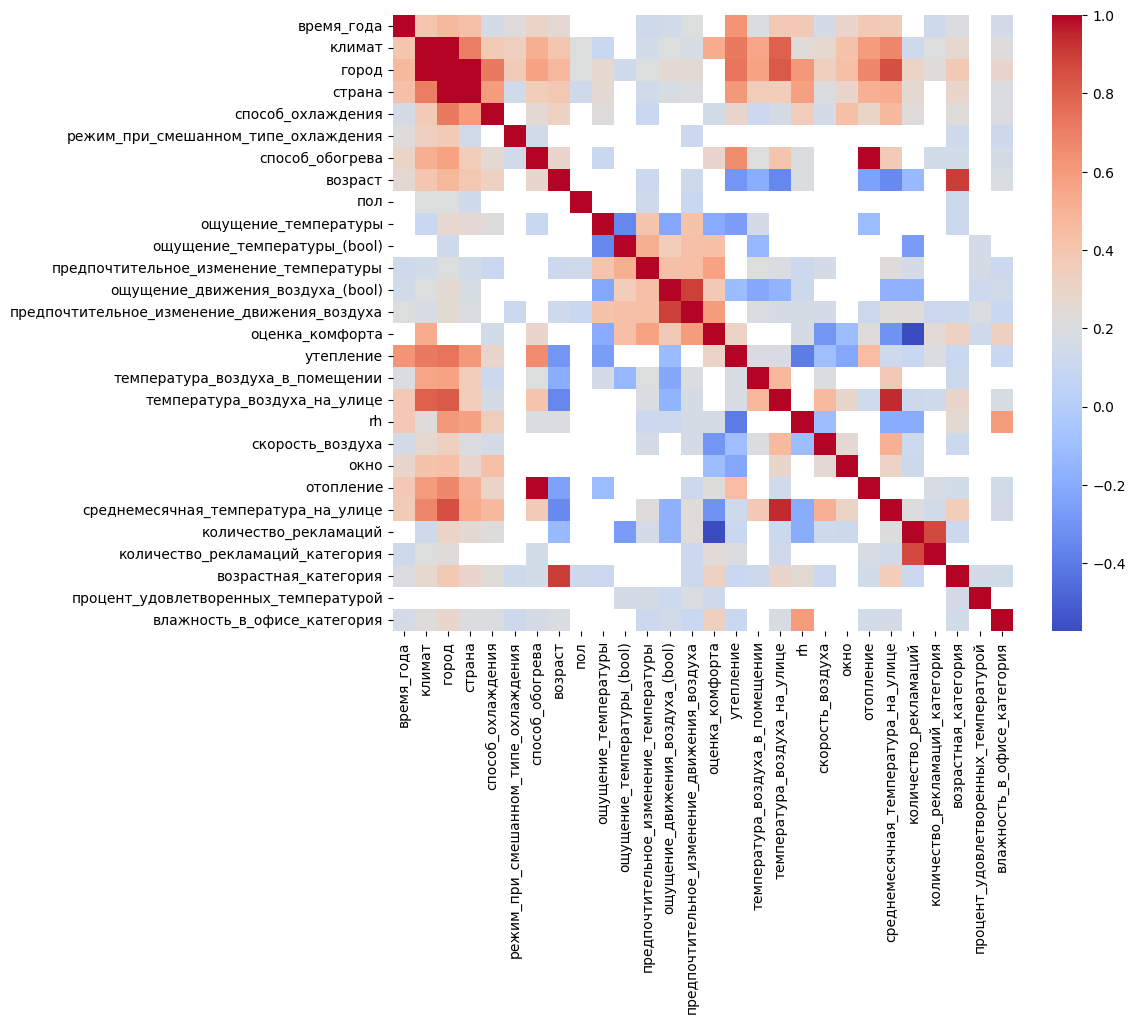

In [185]:
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(filt_corr_df, cmap='coolwarm')

# 3. Проверка гипотез

## 3.1 Гипотезы по заданию

### 3.1.1 Влияет ли способ охлаждения на оценку комфорта?

In [186]:
# проверим гипотезу о том, влияет ли способ_охлаждения на оценку_комфорта
print(df.groupby('способ_охлаждения')['оценка_комфорта'].count())
multi_group_analyze(df, 'способ_охлаждения', 'оценка_комфорта')

способ_охлаждения
Вентиляция            33
Кондиционирование    114
Смешанный             68
Name: оценка_комфорта, dtype: int64
Краскел-Уоллес, стастистика: 5.576116980871483, p-value: 0.061540579626604475


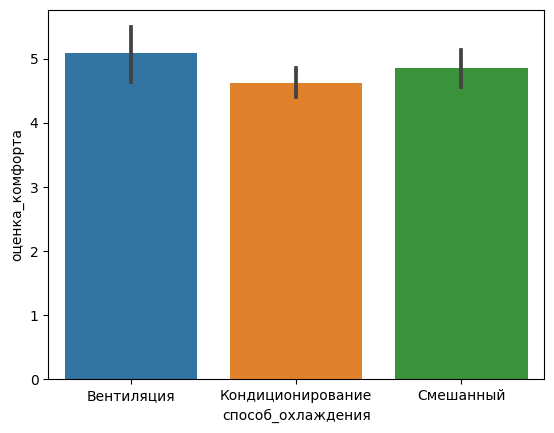

In [187]:
sns.barplot(df, x='способ_охлаждения', y='оценка_комфорта');

In [188]:
# хотя значимость низкая, можно видеть, что при кондиционировании
# оценка комфорта несколько ниже, чем при остальных типах охлаждения

### 3.1.2 Влияет ли пол на оценку комфорта?

In [189]:
# проверим гипотезу о том, влияет ли пол на оценку_комфорта
print(df.groupby('пол')['оценка_комфорта'].count())
group1 = df[df['пол'] == 'Мужской']['оценка_комфорта'].dropna()
group2 = df[df['пол'] == 'Женский']['оценка_комфорта'].dropna()
p_value, method = numeric_hypothesis_test(group1, group2)
print(f'Метод: {method}, p-value: {p_value}')

пол
Женский    44
Мужской    99
Name: оценка_комфорта, dtype: int64
Метод: Манн-Уитни, p-value: 0.1211


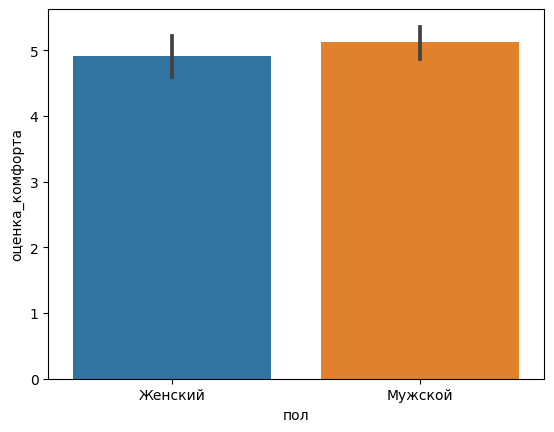

In [190]:
sns.barplot(df, x='пол', y='оценка_комфорта');

In [191]:
# пол явно не влияет на оценку комфорта
# но нужно учитывать, что по США данные о поле отсутствуют

### 3.1.3 Влияет ли возрастная группа на оценку комфорта?

In [192]:
# проверим гипотезу о том, влияет ли возрастная группа на оценку_комфорта
print(df.groupby('возрастная_категория')['оценка_комфорта'].count())

# поскольку для пожилого возраста есть всего 1 человек, попробуем посмотреть
# разницу только для среднего и молодого возраста
group1 = df[df['возрастная_категория'] == 'молодой возраст']['оценка_комфорта'].dropna()
group2 = df[df['возрастная_категория'] == 'средний возраст']['оценка_комфорта'].dropna()
p_value, method = numeric_hypothesis_test(group1, group2)
print(f'Метод: {method}, p-value: {p_value}')

возрастная_категория
молодой возраст    143
пожилой возраст      1
средний возраст     71
Name: оценка_комфорта, dtype: int64
Метод: Манн-Уитни, p-value: 0.0021


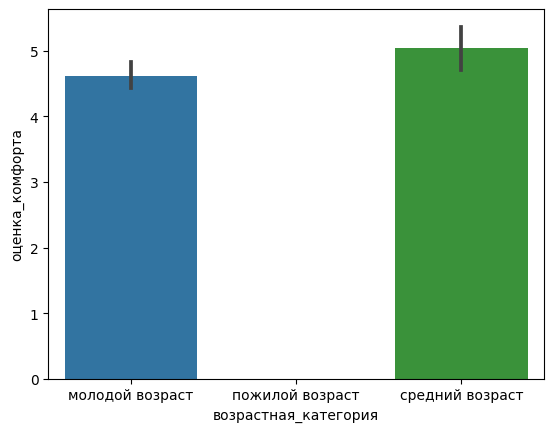

In [193]:
df_for_plot = df[(df['возрастная_категория'] != 'пожилой возраст')].copy()
sns.barplot(df_for_plot, x='возрастная_категория', y='оценка_комфорта');

In [194]:
# возрастная группа достаточно значимо влияет на оценку комфорта
# молодые в целом демонстрируют меньшую оценку

In [195]:
# я бы здесь поменял категории и проверил бы еще раз, потому что с такими категориями
# мало данных

### 3.1.4 Есть ли взаимосвязь между количеством рекламаций и оценкой комфорта?

In [196]:
# проверим гипотезу о связи количества рекламаций и оценкой комфорта
print(df.groupby('количество_рекламаций_категория')['оценка_комфорта'].count())
multi_group_analyze(df, 'количество_рекламаций_категория', 'оценка_комфорта')

количество_рекламаций_категория
мало      207
много       5
средне      3
Name: оценка_комфорта, dtype: int64
Краскел-Уоллес, стастистика: 10.354462998654327, p-value: 0.005643609142064366


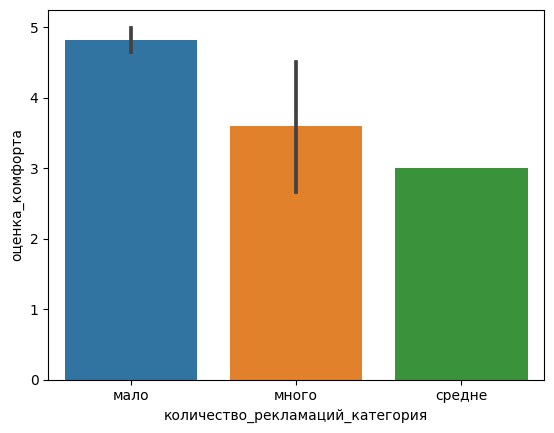

In [197]:
sns.barplot(df, x='количество_рекламаций_категория', y='оценка_комфорта');

In [198]:
# количество рекламаций очень сильно связано с оценкой комфорта

In [199]:
# дополнительно посмотрим, будет ли связь количества рекламаций без категорий
# и оценки комфорта
groups = df[['количество_рекламаций', 'оценка_комфорта']].dropna()
group1 = groups['количество_рекламаций']
group2 = groups['оценка_комфорта']
stat, p_value = spearmanr(group1, group2)
print(f'Корреляция: {stat:.3f}, p-value: {p_value:.3f}')

Корреляция: -0.574, p-value: 0.000


### 3.1.5 Cредняя оценка комфорта отличается в зависимости от страны?

In [200]:
# посмотрим разницу в оценке комфорта в зависимости от страны
print(df.groupby('страна')['оценка_комфорта'].count())
group1 = df[df['страна'] == 'Индия']['оценка_комфорта'].dropna()
group2 = df[df['страна'] == 'США']['оценка_комфорта'].dropna()
p_value, method = numeric_hypothesis_test(group1, group2)
print(f'Метод: {method}, p-value: {p_value}')

страна
Австралия      0
Индия        143
США           72
Name: оценка_комфорта, dtype: int64
Метод: Манн-Уитни, p-value: 0.0


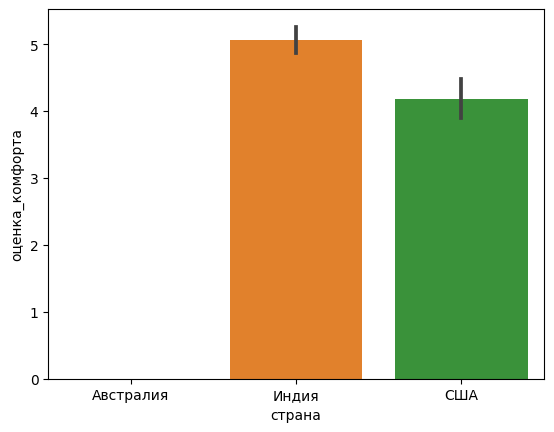

In [201]:
sns.barplot(df, x='страна', y='оценка_комфорта');

## 3.2 Наши гипотезы

### 3.2.1 климат - ощущение_температуры

In [202]:
# посмотрим на связь типа климата и оценки комфорта
print(df.groupby('климат')['ощущение_температуры'].count())
multi_group_analyze(df, 'климат', 'ощущение_температуры')

климат
Cубтропический океанический         270
Влажный субтропический муссонный     35
Жаркий полузасушливый                68
Субтропическое высокогорье           32
Тропическая влажная саванна          77
Name: ощущение_температуры, dtype: int64
Краскел-Уоллес, стастистика: 10.942321501067918, p-value: 0.027219946340584823


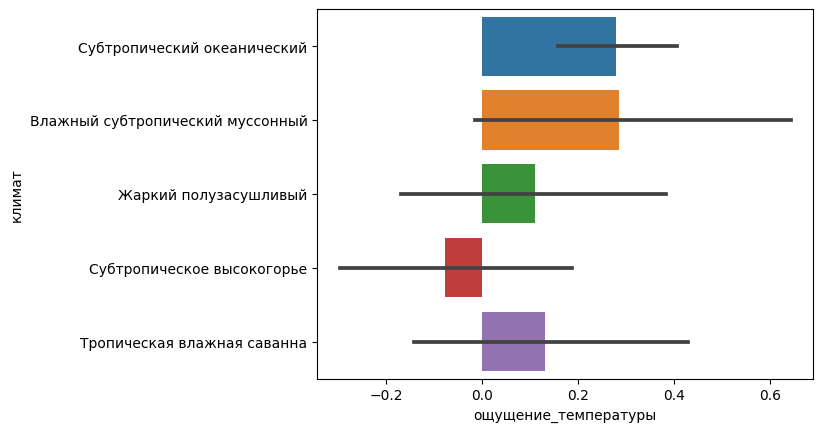

In [203]:
sns.barplot(df, y='климат', x='ощущение_температуры');

In [204]:
# Климат однозначно влияет на ощущение температуры

### 3.2.2 окно - ощущение_движения_воздуха_bool

In [205]:
# проверим связь окон и ощущения движения воздуха
groups = df[['ощущение_движения_воздуха_(bool)', 'окно']].dropna()
corr, p_value = crammer_and_pvalue(groups, 'ощущение_движения_воздуха_(bool)', 'окно')
print(f'Корреляция: {corr}, p-value: {p_value}')

Корреляция: 0.02, p-value: 0.7419


### 3.2.3 влажность__в_офисе_категория - оценка_комфорта

In [206]:
# проверм как связана влажность воздуха и оценка комфорта
print(df.groupby('влажность_в_офисе_категория')['оценка_комфорта'].count())
multi_group_analyze(df, 'влажность_в_офисе_категория', 'оценка_комфорта')

влажность_в_офисе_категория
рекомендуемая        99
сыро                 20
удовлетворительно    96
Name: оценка_комфорта, dtype: int64
Краскел-Уоллес, стастистика: 8.848029639571909, p-value: 0.01198601386973005


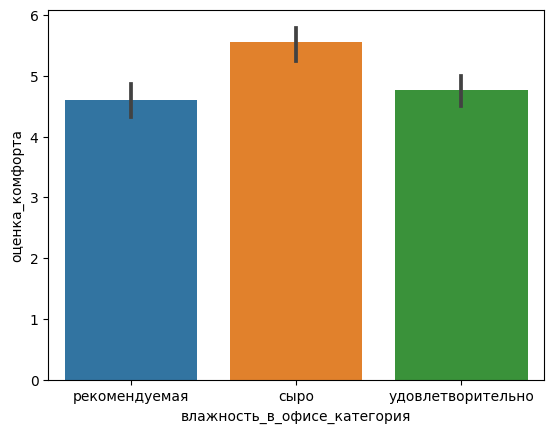

In [207]:
sns.barplot(df, x='влажность_в_офисе_категория', y='оценка_комфорта');

### 3.2.4 rh - ощущение_температуры / ощущение_температуры_bool

In [208]:
print(df.groupby('ощущение_температуры_(bool)')['rh'].count())
group1 = df[df['ощущение_температуры_(bool)'] == 1.0]['rh'].dropna()
group2 = df[df['ощущение_температуры_(bool)'] == 0.0]['rh'].dropna()
p_value, method = numeric_hypothesis_test(group1, group2)
print(f'Метод: {method}, p-value: {p_value}')

ощущение_температуры_(bool)
0.0    102
1.0    380
Name: rh, dtype: int64
Метод: Манн-Уитни, p-value: 0.2067


In [209]:
groups = df[['rh', 'ощущение_температуры']].dropna()
group1 = groups['rh']
group2 = groups['ощущение_температуры']
stat, p_value = spearmanr(group1, group2)
print(f'Корреляция: {stat:.3f}, p-value: {p_value:.4f}')

Корреляция: 0.099, p-value: 0.0293


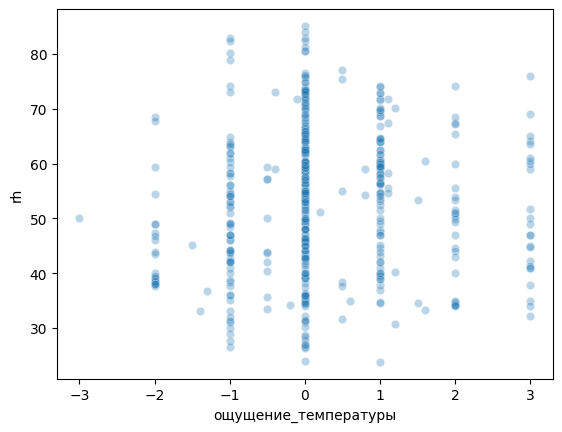

In [210]:
sns.scatterplot(df, y='rh', x='ощущение_температуры', alpha=0.3);

### 3.2.5 скорость_воздуха - оценка_комфорта

In [211]:
# посмотрим на связь скорости воздуха и оценки комфорта
groups = df[['скорость_воздуха', 'оценка_комфорта']].dropna()
group1 = groups['скорость_воздуха']
group2 = groups['оценка_комфорта']
stat, p_value = spearmanr(group1, group2)
print(f'Корреляция: {round(stat, 2)}, p-value: {round(p_value, 4)}')

Корреляция: -0.29, p-value: 0.0


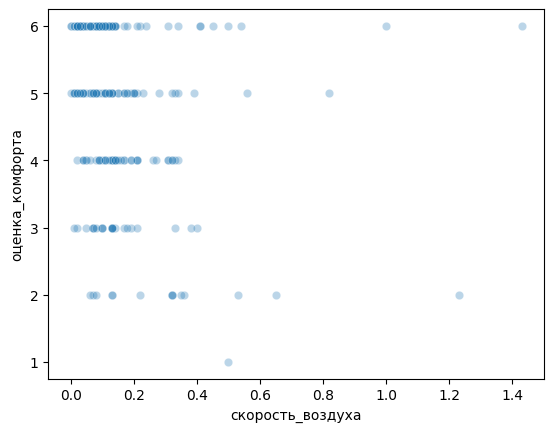

In [212]:
sns.scatterplot(df, x='скорость_воздуха', y='оценка_комфорта', alpha=0.3);

In [213]:
# в целом можно видеть, что чем ниже скорость воздуха, тем выше оценка комфорта

### 3.2.6 температура_воздуха_на_улице - ощущение_температуры

In [214]:
groups = df[['температура_воздуха_на_улице', 'ощущение_температуры']].dropna()
group1 = groups['температура_воздуха_на_улице']
group2 = groups['ощущение_температуры']
stat, p_value = spearmanr(group1, group2)
print(f'Корреляция: {stat:.3f}, p-value: {p_value:.4f}')

Корреляция: -0.043, p-value: 0.3463


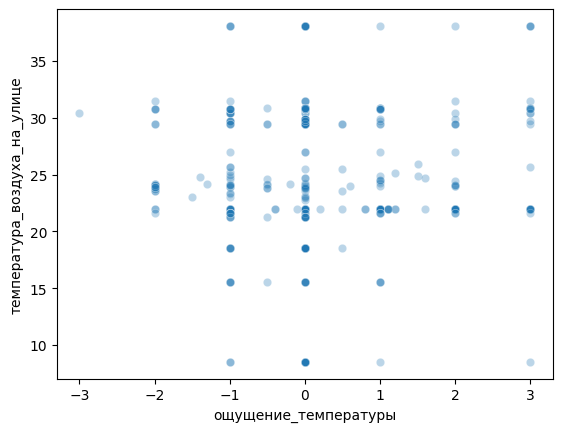

In [215]:
sns.scatterplot(df, y='температура_воздуха_на_улице', x='ощущение_температуры',
                alpha=0.3);

In [216]:
# Факторы не оказывают друг на друга влияние, ведь в помещении чаще будет
# поддерживаться комфортная температура для человека

# 4. Регрессионное моделирование

In [217]:
target = 'температура_воздуха_в_помещении'

In [218]:
data = df[(df['отопление'] == 0)].copy()

In [219]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401 entries, 0 to 481
Data columns (total 28 columns):
 #   Column                                       Non-Null Count  Dtype   
---  ------                                       --------------  -----   
 0   время_года                                   401 non-null    category
 1   климат                                       401 non-null    category
 2   город                                        401 non-null    category
 3   страна                                       401 non-null    category
 4   способ_охлаждения                            401 non-null    category
 5   режим_при_смешанном_типе_охлаждения          301 non-null    category
 6   способ_обогрева                              401 non-null    category
 7   возраст                                      401 non-null    float64 
 8   пол                                          329 non-null    category
 9   ощущение_температуры                         401 non-null    floa

In [220]:
data.isna().mean()

время_года                                     0.000000
климат                                         0.000000
город                                          0.000000
страна                                         0.000000
способ_охлаждения                              0.000000
режим_при_смешанном_типе_охлаждения            0.249377
способ_обогрева                                0.000000
возраст                                        0.000000
пол                                            0.179551
ощущение_температуры                           0.000000
ощущение_температуры_(bool)                    0.000000
предпочтительное_изменение_температуры         0.000000
ощущение_движения_воздуха_(bool)               0.000000
предпочтительное_изменение_движения_воздуха    0.000000
оценка_комфорта                                0.665835
утепление                                      0.000000
температура_воздуха_в_помещении                0.000000
температура_воздуха_на_улице                   0

In [221]:
data['используемый_тип_охлаждения'] =\
data[data['способ_охлаждения'] != 'Смешанный']['способ_охлаждения'].astype('object')
data.loc[data['используемый_тип_охлаждения'].isnull(), 'используемый_тип_охлаждения'] =\
'Смешанный ' + df['режим_при_смешанном_типе_охлаждения'].astype(str)
data['используемый_тип_охлаждения'] = data['используемый_тип_охлаждения'].astype('category')
data = data.drop(['способ_охлаждения', 'режим_при_смешанном_типе_охлаждения'], axis=1)

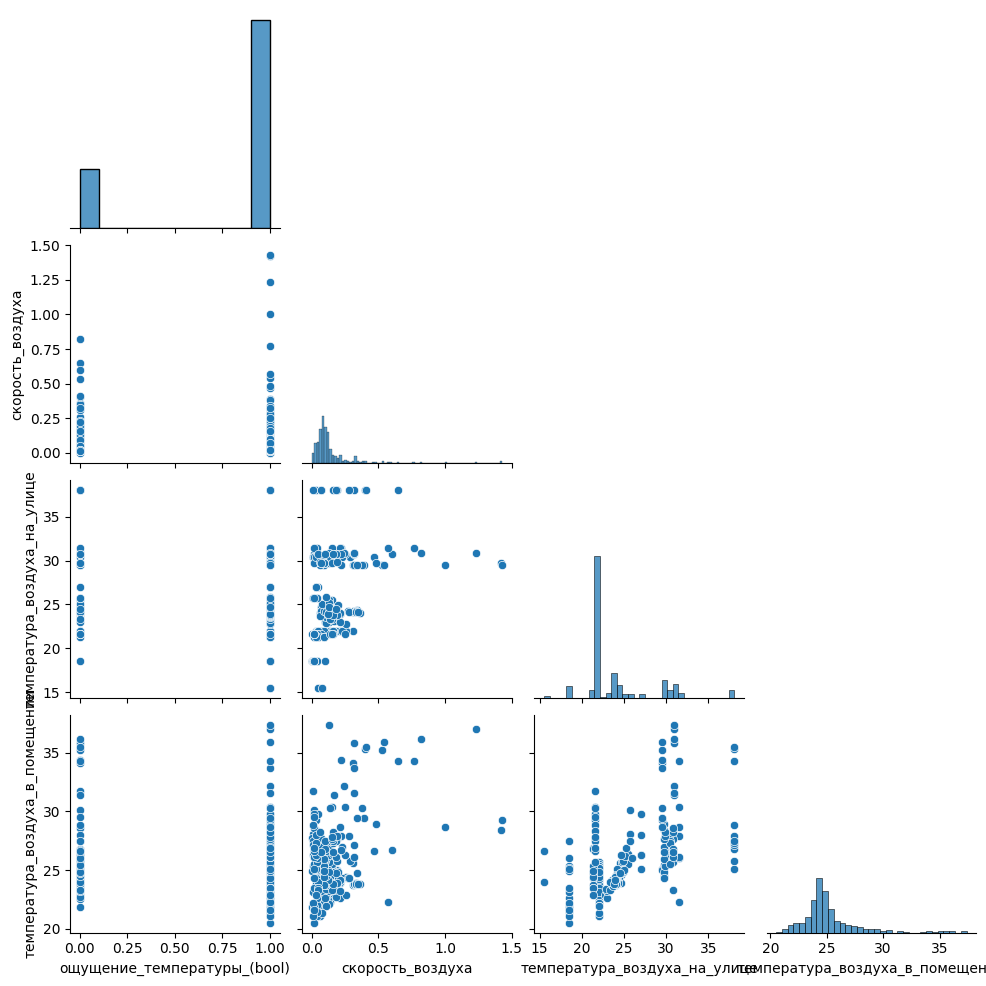

In [222]:
sns.pairplot(data[['ощущение_температуры_(bool)',
                   'скорость_воздуха',
                   'температура_воздуха_на_улице'] + [target]], corner=True);

In [223]:
SIZE = 0.15
RANDOM_STATE = 5

In [224]:
categories = ['время_года', 'климат', 'город',
              'влажность_в_офисе_категория', 'используемый_тип_охлаждения']
numerics = ['ощущение_температуры_(bool)',
            'скорость_воздуха',
            'температура_воздуха_на_улице']

In [225]:
features = data[categories + numerics]
targ = data[target]
x_train, x_test, y_train, y_test = train_test_split(features, targ,
                                                    test_size=SIZE,
                                                    random_state=RANDOM_STATE)

In [226]:
ohe = OneHotEncoder(sparse_output=False, drop='first')

def get_ohe(t, categ):
    temp = pd.DataFrame(data=ohe.transform(t[categ]), columns=ohe.get_feature_names_out())
    data = pd.concat([t.reset_index(drop=True), temp], axis=1)
    data = data.drop(columns=categ, axis=1)
    return data

ohe.fit(x_train[categories])
x_train = get_ohe(x_train, categories)
x_test = get_ohe(x_test, categories)

In [227]:
scaler = StandardScaler()
scaler.fit(x_train[numerics])
x_train[numerics] = scaler.transform(x_train[numerics])
x_test[numerics] = scaler.transform(x_test[numerics])

In [228]:
model = LinearRegression().fit(x_train, y_train)

In [229]:
prediction = model.predict(x_test)

In [230]:
# метрики, переведённые в проценты
r2 = round(r2_score(y_test, prediction.flatten()) * 100, 2)
mape = round(mean_absolute_percentage_error(y_test, prediction.flatten()) * 100, 2)

In [231]:
coeff_df = pd.DataFrame(model.coef_.flatten(), x_test.columns, columns=['коэффициенты_модели'])
coeff_df.sort_values(by='коэффициенты_модели', ascending=False)

,коэффициенты_модели
город_Дели,2.898632
климат_Влажный субтропический муссонный,2.898632
климат_Жаркий полузасушливый,1.391619
город_Хайдарабад,1.343351
время_года_Лето,1.222434
температура_воздуха_на_улице,0.980644
время_года_Зима,0.646399
скорость_воздуха,0.325414
время_года_Осень,0.264176
влажность_в_офисе_категория_удовлетворительно,0.025442


In [232]:
def quality_model(fact, pred):
  '''
  Функция выводит:
  - R2 для регрессионных моделей
  - Графики остатков: гистограмма, скаттерплот "отстатки - предсказанные значения"
  '''
  params = {'axes.labelsize': 14, 'figure.titlesize': 18, 'xtick.labelsize': 12,
            'ytick.labelsize': 12, 'legend.fontsize': 12}
  plt.rcParams.update(params)

  fact = pd.DataFrame(fact.reset_index(drop=True))
  pred = pd.DataFrame(pred.flatten(), columns=['предсказанное'])
  df = pd.concat([fact, pred], axis=1)
  df['остаток'] = df[target] - df['предсказанное']

  print('\033[1m' + 'Расчёт R2:' + '\033[0m')
  print('\033[1m' + 'Учтённые факторы на', round(r2_score(df[target], df['предсказанное']) * 100, 2),
        '% объясняют целевое значение' + '\033[0m')

  fig, ax = plt.subplots(1, 2, figsize=(9, 3))
  plt.tight_layout()
  plt.suptitle('Анализ остатков модели', y=1.05)

  sns.scatterplot(data=df, x='предсказанное', y=df['остаток'], ax=ax[0])
  sns.histplot(x=df['остаток'], bins=10, kde=True, ax=ax[1])

  ax[1].axvline(x=df['остаток'].mean(), color='r', label='mean')
  ax[1].axvline(x=df['остаток'].median(), color='tab:orange', label='median')

  ax[0].set_xlabel('Предсказанные значения')
  ax[1].set_ylabel('')
  ax[1].legend()
  plt.show()
  plt.style.use('default')

Расчёт R2:
Учтённые факторы на 60.98 % объясняют целевое значение


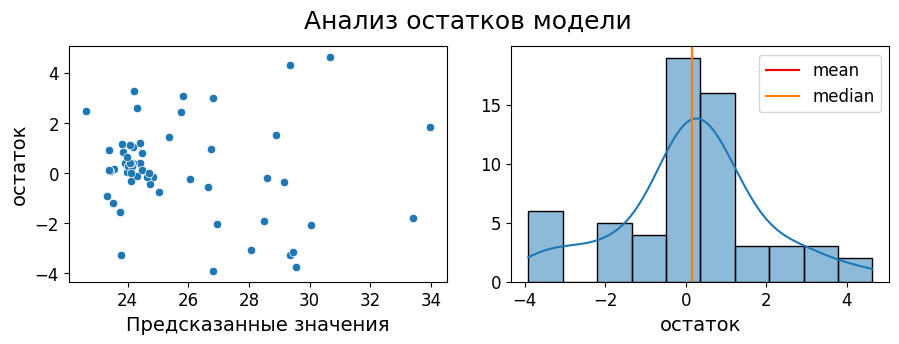

In [233]:
quality_model(y_test, prediction)